<a href="https://colab.research.google.com/github/cpwan/citadel-summer-datathon-2021/blob/eda/pairwise_spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependency

In [1]:
# !pip install pysal -q
# !pip install plotly==5.1.0 -q

# Download data

In [1]:
!mkdir Datasets
!gdown --id 1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW -O dataset.zip
!gdown --id 1Vrm1iQq_czZkML-CgGDGw2rx5imTJgp8 -O Datasets/loc.csv
!gdown --id 16eniKvdJfRVoGkGD6EwCIomYYlxleqRt -O calendar_geo.csv
!gdown --id 1I7aOG6jHt6v4XTXCqmIwfuF7IZFAQVOj -O calendar_monthly.csv
!gdown --id 1274ERtVlFQuRG0zCG148xTXE-5AQEOwi -O occu-rate-per-listing.csv

Downloading...
From: https://drive.google.com/uc?id=1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW
To: /content/dataset.zip
69.1MB [00:01, 56.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Vrm1iQq_czZkML-CgGDGw2rx5imTJgp8
To: /content/Datasets/loc.csv
3.41MB [00:00, 53.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=16eniKvdJfRVoGkGD6EwCIomYYlxleqRt
To: /content/calendar_geo.csv
100% 357k/357k [00:00<00:00, 21.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I7aOG6jHt6v4XTXCqmIwfuF7IZFAQVOj
To: /content/calendar_monthly.csv
19.0MB [00:00, 88.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1274ERtVlFQuRG0zCG148xTXE-5AQEOwi
To: /content/occu-rate-per-listing.csv
100% 1.84M/1.84M [00:00<00:00, 59.0MB/s]


In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: Datasets/econ_state.csv  
  inflating: Datasets/demographics.csv  
  inflating: Datasets/venues.csv.gz  
  inflating: Datasets/real_estate.csv.gz  
  inflating: Datasets/listings.csv   
  inflating: Datasets/calendar.csv.gz  


In [3]:
!gzip -dk Datasets/*.gz

# Load data

In [4]:
# dsets: name of csv
# regions: the geo-region to look at, specified by the filename of the geojsons
dsets=['listings','calendar','demographics','econ_state','real_estate','venues']
regions=['los-angeles', 'asheville', 'austin', 'nashville', 'new-orleans']

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from pathlib import Path

from collections import Counter
import sklearn
import sklearn.neighbors
from scipy import stats

from sklearn.preprocessing import MultiLabelBinarizer


%matplotlib inline

# Preprocessing

## venues

In [6]:
dset='venues'
df_venues=pd.read_csv(f'./Datasets/{dset}.csv')
df_venues['city'].replace({'new orleans':'new-orleans','los angeles':'los-angeles'},inplace=True)
df_venues.head()

,city,id,latitude,longitude,name,rating,types
0,asheville,8736e812595db852ccab223019a477b918b64d4d,35.442805,-82.264081,The Esmeralda Inn & Restaurant,4.4,"['lodging', 'restaurant', 'food', 'point_of_in..."
1,asheville,479c99c6cc5aa91a6161fecc48bd24258a74bd58,35.564035,-82.278943,Straightaway Cafe,4.5,"['restaurant', 'food', 'point_of_interest', 'e..."
2,asheville,3e41ce673ee203416cb6f44894e49b2ee93347b1,35.564140,-82.278953,straightaway cafe,NaN,"['restaurant', 'food', 'point_of_interest', 'e..."
3,asheville,ce0b0e6fc251f546370fed20d39778ea796e5475,35.646791,-82.299074,The Huckleberry Cafe,5.0,"['restaurant', 'food', 'point_of_interest', 'e..."
4,asheville,f60446561634f4d44e6563dcf17f2b65eb4096f2,35.752135,-82.273258,Mount Mitchell State Park- Restaurant,4.0,"['restaurant', 'food', 'point_of_interest', 'e..."


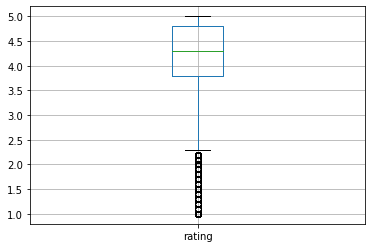

In [7]:
df_venues.boxplot(column='rating')

In [8]:
# get total number of each type of venues 
c=df_venues['types'].apply(lambda x: Counter(eval(x))).sum()
venuesCount=pd.DataFrame.from_dict(dict(c.most_common()),orient='index').rename(columns={0:'Count'})
venuesCount.to_csv('venues_count.csv')
venuesCount

,Count
point_of_interest,121007
establishment,121007
store,55114
food,31473
transit_station,24487
...,...
synagogue,3
neighborhood,2
police,2
city_hall,2


In [9]:
# convert the venues type to one-hot encodings

# convert 'string of list' to 'list'
# Warning: it's assume the conversion is safe,
#          please ensure each value represents a list but not a malicious command
df_venues['types']=df_venues['types'].apply(lambda x: eval(x)) 

# obtain one-hot encoding with sklearn.preprocessing.MultiLabelBinarizer
mlb = MultiLabelBinarizer()
oneHot=pd.DataFrame(mlb.fit_transform(df_venues['types']),
                          columns=mlb.classes_,
                          index=df_venues.index)


assert all(oneHot.sum(axis=1)==df_venues['types'].apply(lambda x: len(x))), "Mismatch in the one-hot encoding!"

df_venues_onehot = df_venues.join(oneHot)


## listings

In [10]:
# join the occupancy rate and the geo-coords

df_orate=pd.read_csv('occu-rate-per-listing.csv')
df_loc=pd.read_csv('Datasets/loc.csv')
df_listings=df_orate.set_index('listing_id').join(df_loc.set_index('id'))
df_listings=df_listings.reset_index().rename(columns={'index':'listing_id'})
df_listings.to_csv('listings_join_cal.csv',index=None)


## summary per city

In [11]:
# obtain per-city listings and venues 
# (assume no interaction among objects in different cities)
df_venues_onehot_perCity=dict( [*df_venues_onehot.groupby('city')])
df_listings_perCity=dict( [*df_listings.groupby('metropolitan')])

In [12]:
# listings per city
print('listings per city')
{region:len(df_listings_perCity[region]) for region in regions}

listings per city


{'asheville': 864,
 'austin': 9658,
 'los-angeles': 31155,
 'nashville': 3277,
 'new-orleans': 5305}

In [13]:
# venues per city
print('venues per city')
{region:len(df_venues_onehot_perCity[region]) for region in regions}

venues per city


{'asheville': 6436,
 'austin': 18708,
 'los-angeles': 66492,
 'nashville': 10491,
 'new-orleans': 18880}

# Find the venues in the neighborhood of listings

In [14]:
def getNbhd(X,Y,r):
  '''
  X: data to fit
  Y: search neighbours of y in X
  r: radius in km
  '''
  nnTree=sklearn.neighbors.BallTree(X,metric='haversine')
  earth_radius=6371
  nbhd=nnTree.query_radius(Y,r=r/earth_radius) # in km
  return nbhd

In [15]:

def countVenuesInNbhd(r,region,df_listings,df_venues,oneHotCol):
  # prepare the data for knn fit
  Y=df_listings[['latitude','longitude']].values 
  Y=np.radians(Y) # in radian
  X=df_venues[['latitude','longitude']].values
  X=np.radians(X) # in radian
  print(f'In {region}: {len(Y)} listings, {len(X)} venues')

  # get the nbhd
  nbhd=getNbhd(X,Y,r)
  print('Done finding the nbhd')
  pd.DataFrame([*map(len,nbhd)]).rename(columns={0:f'Number of venues in {r}-km nbhd'}).boxplot(vert=False)
  plt.show()

  # append empty columns after the current listing table
  empty_one_hot=df_listings.reindex(columns=oneHotCol,fill_value=0)
  df_listings_nbhd=df_listings.join(empty_one_hot)

  # one hot vector of the venues, with only the category values but no other information
  oneHotValues=df_venues[oneHotCol]
  # aggregate the count of each type of venues in the bnhds of each listings
  aggregates=[]
  for i in range(len(nbhd)):
    aggregates.append(oneHotValues.iloc[nbhd[i]].sum().values)
  # merge the count table back to the listing table
  df_listings_nbhd.loc[:,oneHotCol]=np.array(aggregates)
  # get the total count of venues in the nbhd
  df_listings_nbhd['num_venues']=df_listings_nbhd[oneHotCol].sum(axis=1)

  Path(f"./{region}").mkdir(parents=True, exist_ok=True)
  out_fname=f'./{region}/listings_{r}-km_nbhd.csv'
  print('Processed and saved to ', out_fname)
  df_listings_nbhd.to_csv(out_fname,index=None)
  return df_listings_nbhd

In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


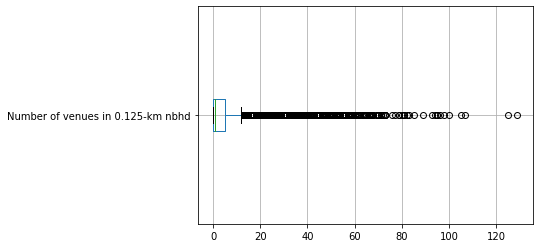

Processed and saved to  ./los-angeles/listings_0.125-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


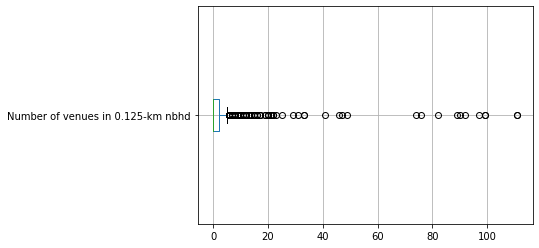

Processed and saved to  ./asheville/listings_0.125-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


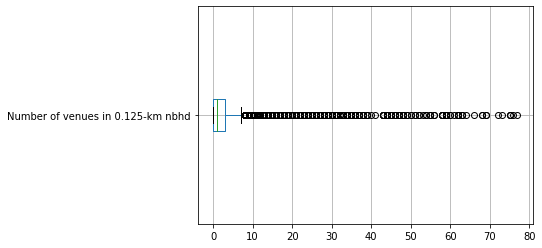

Processed and saved to  ./austin/listings_0.125-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


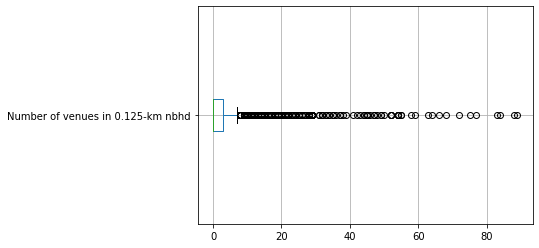

Processed and saved to  ./nashville/listings_0.125-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


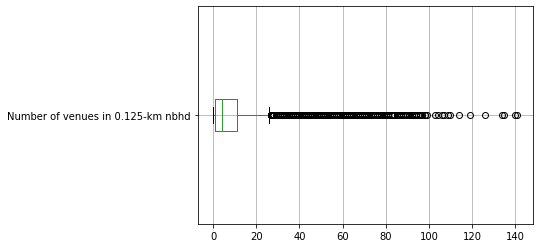

Processed and saved to  ./new-orleans/listings_0.125-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


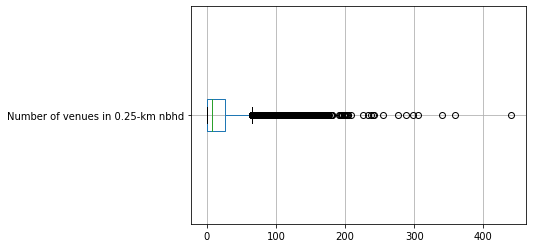

Processed and saved to  ./los-angeles/listings_0.25-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


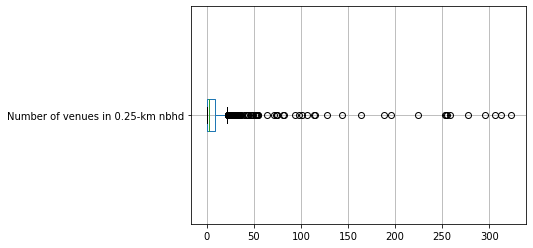

Processed and saved to  ./asheville/listings_0.25-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


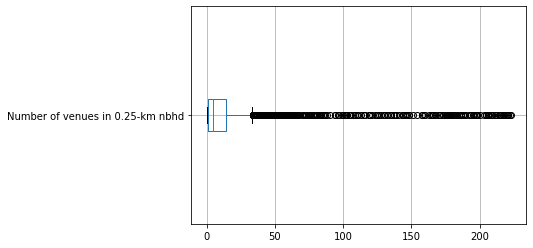

Processed and saved to  ./austin/listings_0.25-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


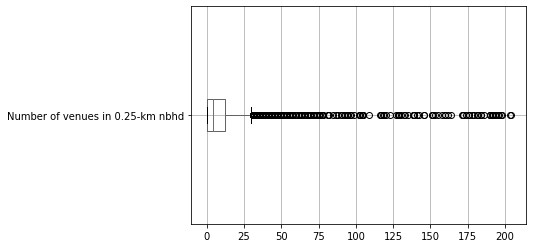

Processed and saved to  ./nashville/listings_0.25-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


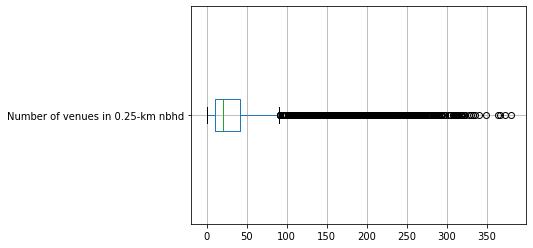

Processed and saved to  ./new-orleans/listings_0.25-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


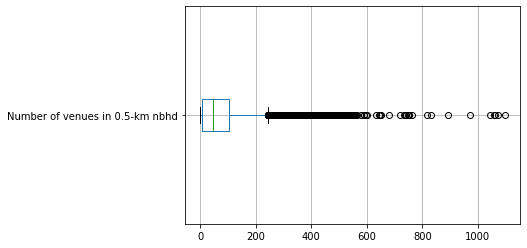

Processed and saved to  ./los-angeles/listings_0.5-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


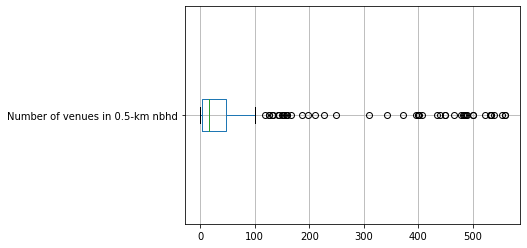

Processed and saved to  ./asheville/listings_0.5-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


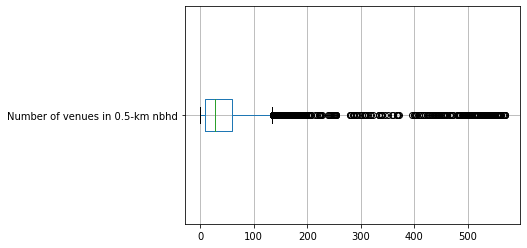

Processed and saved to  ./austin/listings_0.5-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


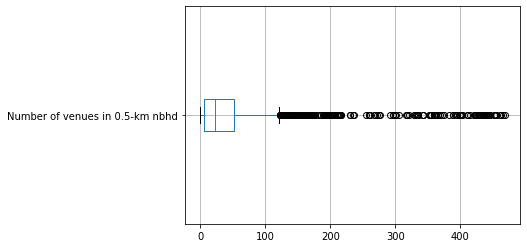

Processed and saved to  ./nashville/listings_0.5-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


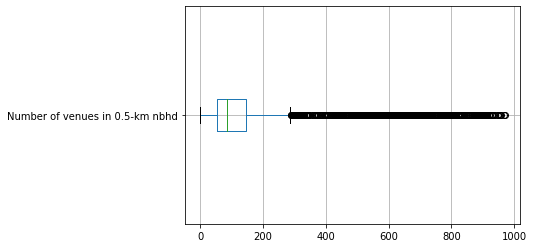

Processed and saved to  ./new-orleans/listings_0.5-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


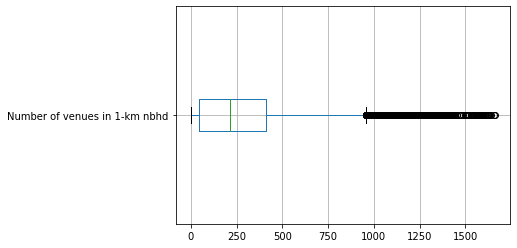

Processed and saved to  ./los-angeles/listings_1-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


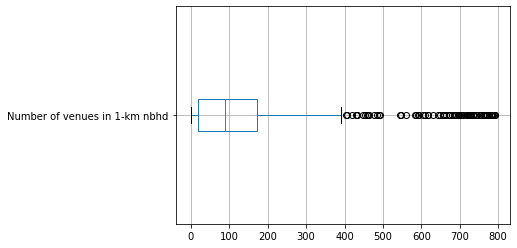

Processed and saved to  ./asheville/listings_1-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


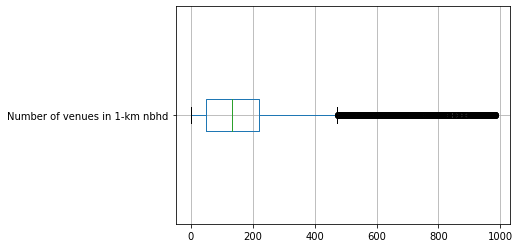

Processed and saved to  ./austin/listings_1-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


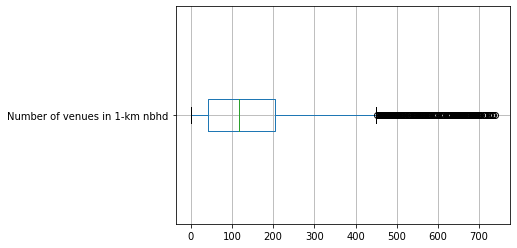

Processed and saved to  ./nashville/listings_1-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


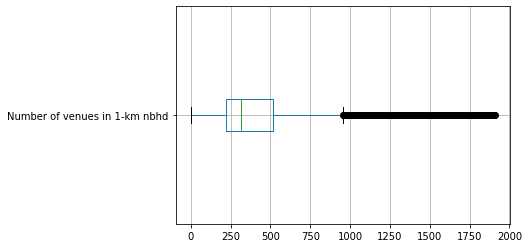

Processed and saved to  ./new-orleans/listings_1-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


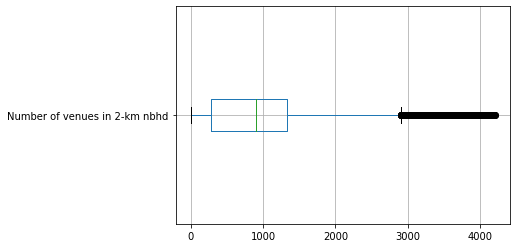

Processed and saved to  ./los-angeles/listings_2-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


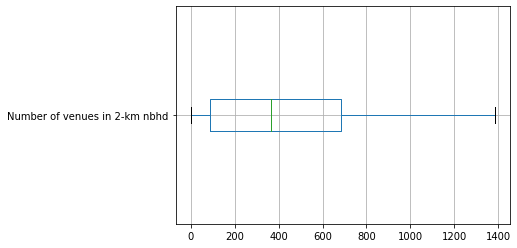

Processed and saved to  ./asheville/listings_2-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


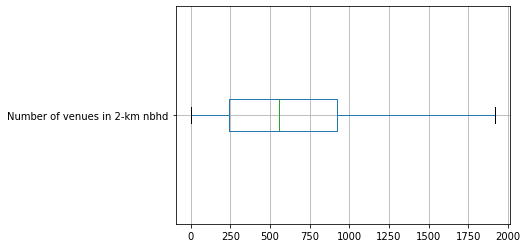

Processed and saved to  ./austin/listings_2-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


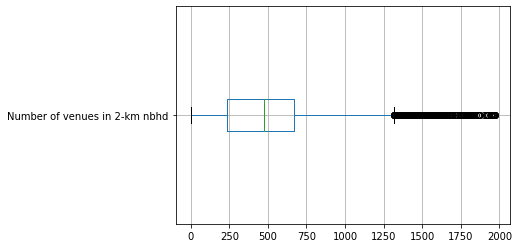

Processed and saved to  ./nashville/listings_2-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


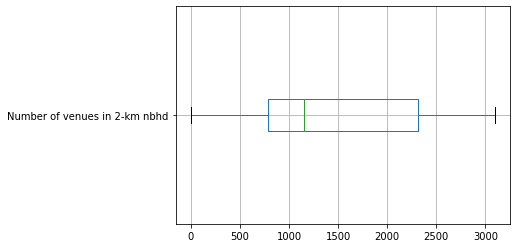

Processed and saved to  ./new-orleans/listings_2-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


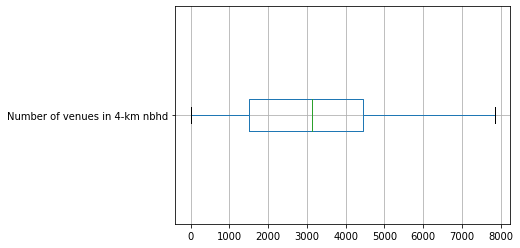

Processed and saved to  ./los-angeles/listings_4-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


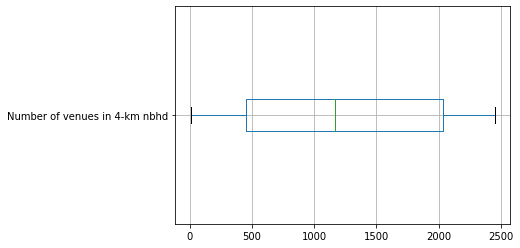

Processed and saved to  ./asheville/listings_4-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


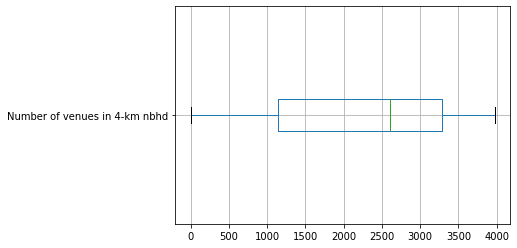

Processed and saved to  ./austin/listings_4-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


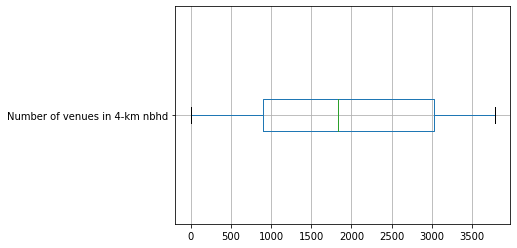

Processed and saved to  ./nashville/listings_4-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


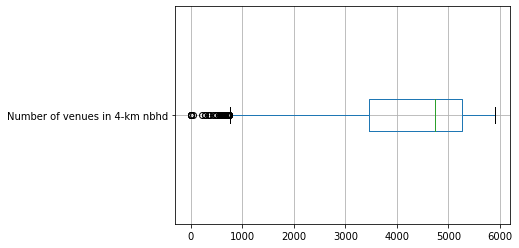

Processed and saved to  ./new-orleans/listings_4-km_nbhd.csv


In [16]:

oneHotCol=oneHot.columns
listings_nbhd_allCity={}
for r in [0.125,0.25,0.5,1,2,4]:
  for region in regions:
    df=countVenuesInNbhd(r,
                        region,
                        df_listings_perCity[region],
                        df_venues_onehot_perCity[region],
                        oneHotCol)
    listings_nbhd_allCity[region]=df
  df_listings_nbhd_all=pd.concat(listings_nbhd_allCity).set_index('listing_id')
  df_listings_nbhd_all.to_csv(f'listings_{r}-km_nbhd.csv')
  df_listings_nbhd_all[[*oneHotCol]+['num_venues']].to_csv(f'listings_{r}-km_nbhd_compact.csv')

In [17]:
!zip listings_nbhd.zip *nbhd.csv

  adding: listings_0.125-km_nbhd.csv (deflated 83%)
  adding: listings_0.25-km_nbhd.csv (deflated 80%)
  adding: listings_0.5-km_nbhd.csv (deflated 76%)
  adding: listings_1-km_nbhd.csv (deflated 72%)
  adding: listings_2-km_nbhd.csv (deflated 68%)
  adding: listings_4-km_nbhd.csv (deflated 65%)


In [18]:
!zip listings_nbhd_compact.zip *nbhd_compact.csv

  adding: listings_0.125-km_nbhd_compact.csv (deflated 93%)
  adding: listings_0.25-km_nbhd_compact.csv (deflated 89%)
  adding: listings_0.5-km_nbhd_compact.csv (deflated 84%)
  adding: listings_1-km_nbhd_compact.csv (deflated 78%)
  adding: listings_2-km_nbhd_compact.csv (deflated 73%)
  adding: listings_4-km_nbhd_compact.csv (deflated 68%)


In [19]:

def countListingsInNbhd(r,region,df_listings):
  # prepare the data for knn fit
  Y=df_listings[['latitude','longitude']].values 
  Y=np.radians(Y) # in radian
  print(f'In {region}: {len(Y)} listings')

  # get the nbhd
  nbhd=getNbhd(Y,Y,r)
  print('Done finding the nbhd')
  pd.DataFrame([*map(len,nbhd)]).rename(columns={0:f'Number of venues in {r}-km nbhd'}).boxplot(vert=False)
  plt.show()

  df_listings_nbhd=df_listings
  df_listings_nbhd[f'listings_{r}-km_nbhd']=np.array([*map(len,nbhd)])

  Path(f"./{region}").mkdir(parents=True, exist_ok=True)
  out_fname=f'./{region}/num_listings_{r}-km_nbhd.csv'
  print('Processed and saved to ', out_fname)
  df_listings_nbhd.to_csv(out_fname,index=None)
  return df_listings_nbhd

In los-angeles: 31155 listings
Done finding the nbhd


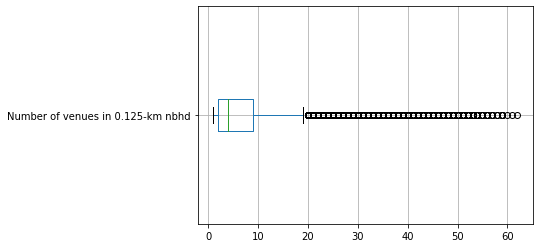

Processed and saved to  ./los-angeles/num_listings_0.125-km_nbhd.csv
In asheville: 864 listings
Done finding the nbhd


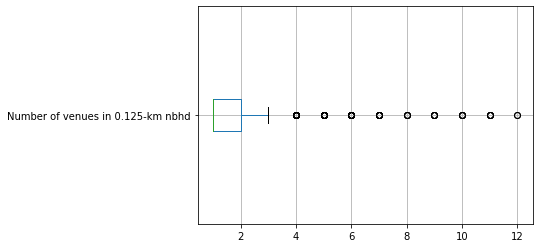

Processed and saved to  ./asheville/num_listings_0.125-km_nbhd.csv
In austin: 9658 listings
Done finding the nbhd


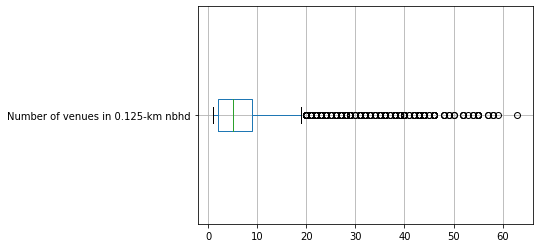

Processed and saved to  ./austin/num_listings_0.125-km_nbhd.csv
In nashville: 3277 listings
Done finding the nbhd


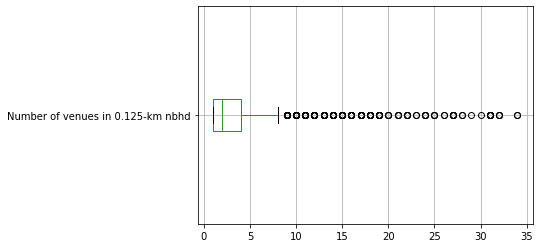

Processed and saved to  ./nashville/num_listings_0.125-km_nbhd.csv
In new-orleans: 5305 listings
Done finding the nbhd


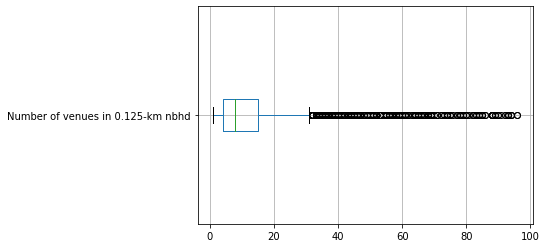

Processed and saved to  ./new-orleans/num_listings_0.125-km_nbhd.csv
In los-angeles: 31155 listings
Done finding the nbhd


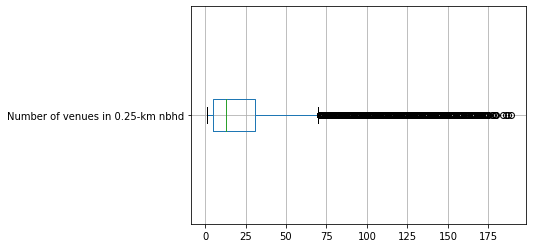

Processed and saved to  ./los-angeles/num_listings_0.25-km_nbhd.csv
In asheville: 864 listings
Done finding the nbhd


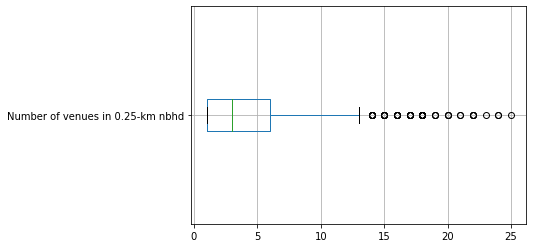

Processed and saved to  ./asheville/num_listings_0.25-km_nbhd.csv
In austin: 9658 listings
Done finding the nbhd


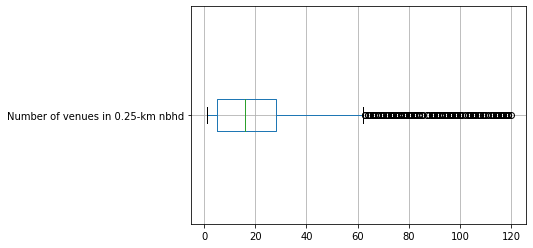

Processed and saved to  ./austin/num_listings_0.25-km_nbhd.csv
In nashville: 3277 listings
Done finding the nbhd


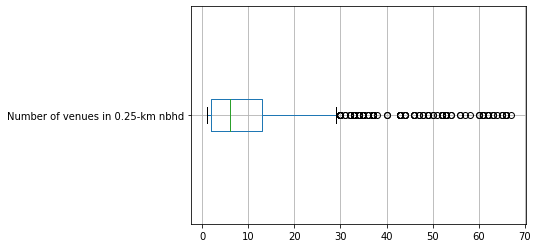

Processed and saved to  ./nashville/num_listings_0.25-km_nbhd.csv
In new-orleans: 5305 listings
Done finding the nbhd


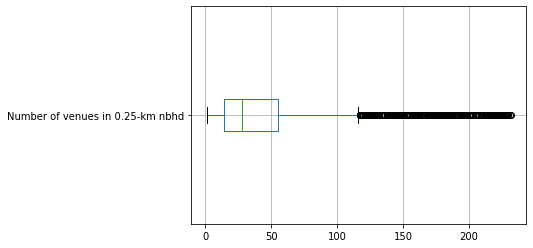

Processed and saved to  ./new-orleans/num_listings_0.25-km_nbhd.csv
In los-angeles: 31155 listings
Done finding the nbhd


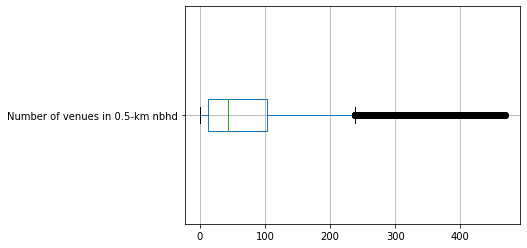

Processed and saved to  ./los-angeles/num_listings_0.5-km_nbhd.csv
In asheville: 864 listings
Done finding the nbhd


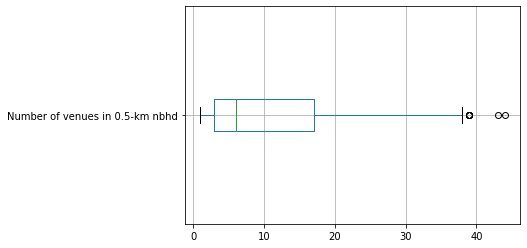

Processed and saved to  ./asheville/num_listings_0.5-km_nbhd.csv
In austin: 9658 listings
Done finding the nbhd


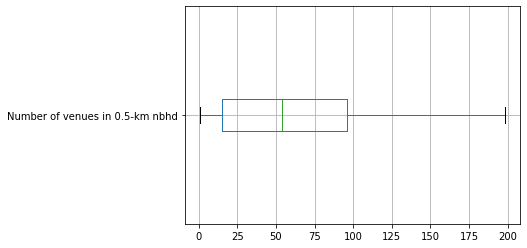

Processed and saved to  ./austin/num_listings_0.5-km_nbhd.csv
In nashville: 3277 listings
Done finding the nbhd


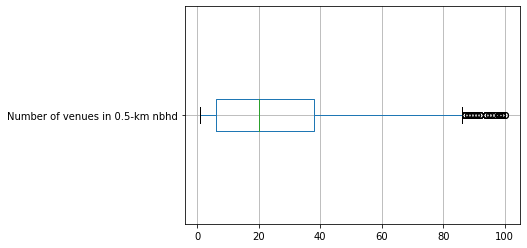

Processed and saved to  ./nashville/num_listings_0.5-km_nbhd.csv
In new-orleans: 5305 listings
Done finding the nbhd


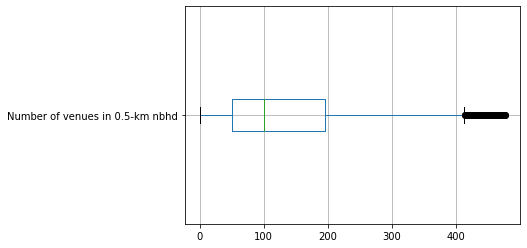

Processed and saved to  ./new-orleans/num_listings_0.5-km_nbhd.csv
In los-angeles: 31155 listings
Done finding the nbhd


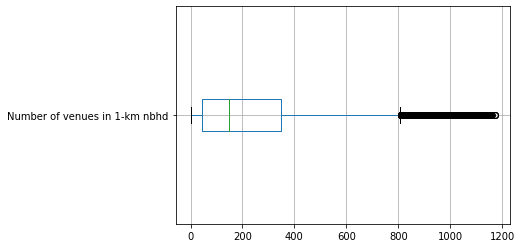

Processed and saved to  ./los-angeles/num_listings_1-km_nbhd.csv
In asheville: 864 listings
Done finding the nbhd


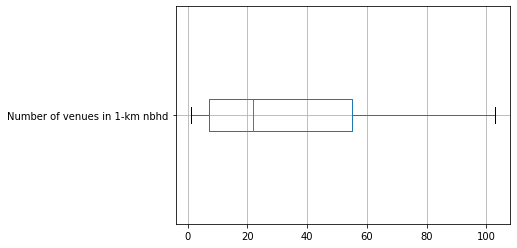

Processed and saved to  ./asheville/num_listings_1-km_nbhd.csv
In austin: 9658 listings
Done finding the nbhd


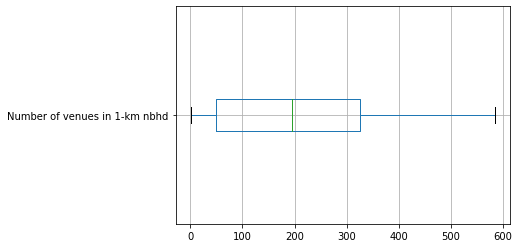

Processed and saved to  ./austin/num_listings_1-km_nbhd.csv
In nashville: 3277 listings
Done finding the nbhd


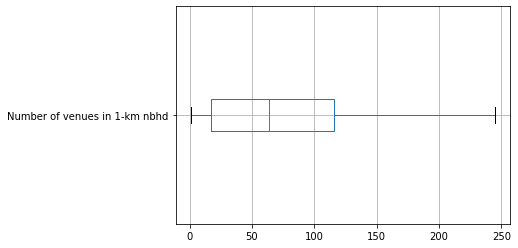

Processed and saved to  ./nashville/num_listings_1-km_nbhd.csv
In new-orleans: 5305 listings
Done finding the nbhd


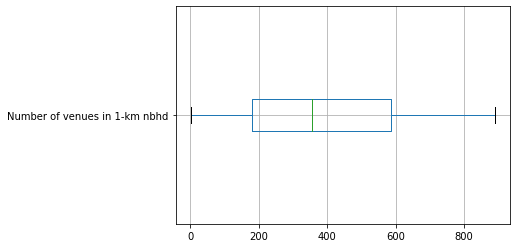

Processed and saved to  ./new-orleans/num_listings_1-km_nbhd.csv
In los-angeles: 31155 listings
Done finding the nbhd


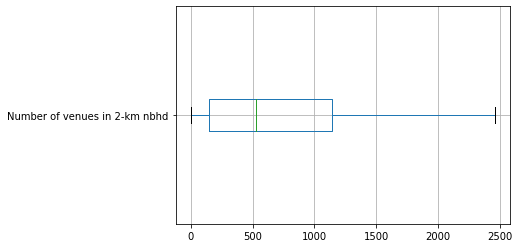

Processed and saved to  ./los-angeles/num_listings_2-km_nbhd.csv
In asheville: 864 listings
Done finding the nbhd


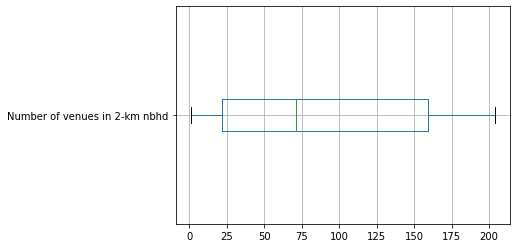

Processed and saved to  ./asheville/num_listings_2-km_nbhd.csv
In austin: 9658 listings
Done finding the nbhd


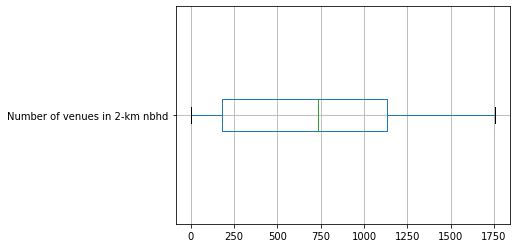

Processed and saved to  ./austin/num_listings_2-km_nbhd.csv
In nashville: 3277 listings
Done finding the nbhd


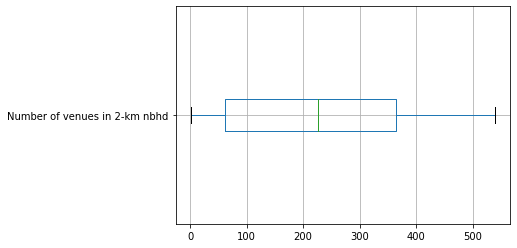

Processed and saved to  ./nashville/num_listings_2-km_nbhd.csv
In new-orleans: 5305 listings
Done finding the nbhd


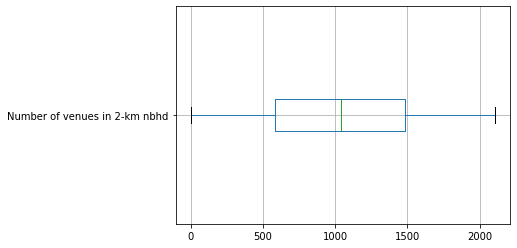

Processed and saved to  ./new-orleans/num_listings_2-km_nbhd.csv
In los-angeles: 31155 listings
Done finding the nbhd


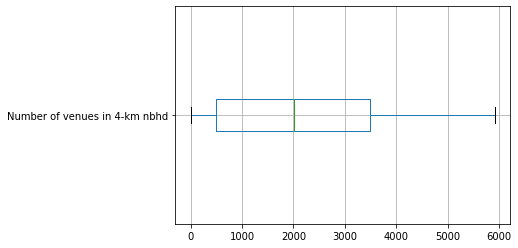

Processed and saved to  ./los-angeles/num_listings_4-km_nbhd.csv
In asheville: 864 listings
Done finding the nbhd


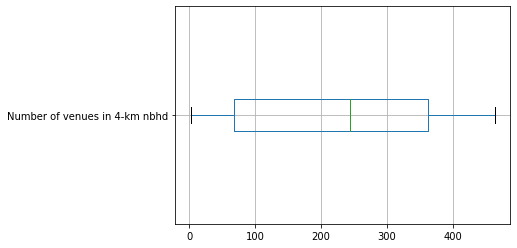

Processed and saved to  ./asheville/num_listings_4-km_nbhd.csv
In austin: 9658 listings
Done finding the nbhd


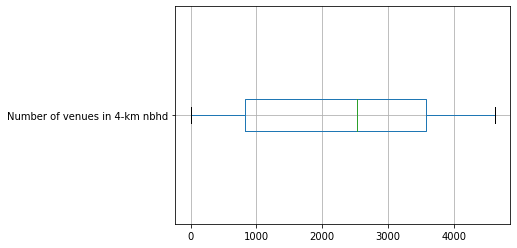

Processed and saved to  ./austin/num_listings_4-km_nbhd.csv
In nashville: 3277 listings
Done finding the nbhd


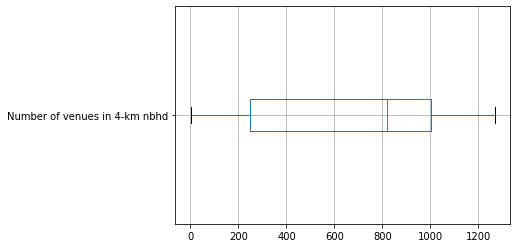

Processed and saved to  ./nashville/num_listings_4-km_nbhd.csv
In new-orleans: 5305 listings
Done finding the nbhd


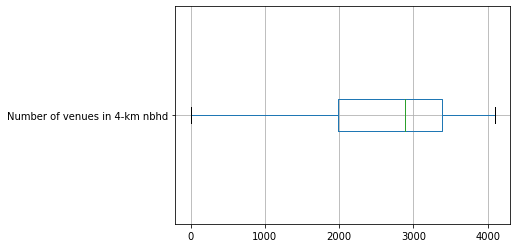

Processed and saved to  ./new-orleans/num_listings_4-km_nbhd.csv


In [20]:

listings_nbhd_allCity={}
for r in [0.125,0.25,0.5,1,2,4]:
  for region in regions:
    df=countListingsInNbhd(r,
                        region,
                        df_listings_perCity[region])
    df_listings_perCity[region]=df
    listings_nbhd_allCity[region]=df
  df_listings_nbhd_all=pd.concat(listings_nbhd_allCity).set_index('listing_id')
  df_listings_nbhd_all.to_csv(f'listings_{r}-km_nbhd_listings.csv')


In [21]:

def countVenuesInNbhd(r,region,df_listings,df_venues):
  # prepare the data for knn fit
  Y=df_listings[['latitude','longitude']].values 
  Y=np.radians(Y) # in radian
  X=df_venues[['latitude','longitude']].values
  X=np.radians(X) # in radian
  print(f'In {region}: {len(Y)} listings, {len(X)} venues')

  # get the nbhd
  nbhd=getNbhd(X,Y,r)
  print('Done finding the nbhd')
  pd.DataFrame([*map(len,nbhd)]).rename(columns={0:f'Number of venues in {r}-km nbhd'}).boxplot(vert=False)
  plt.show()


  df_listings_nbhd=df_listings
  df_listings_nbhd[f'venues_{r}-km_nbhd']=np.array([*map(len,nbhd)])

  Path(f"./{region}").mkdir(parents=True, exist_ok=True)
  out_fname=f'./{region}/num_venues_{r}-km_nbhd.csv'
  print('Processed and saved to ', out_fname)
  df_listings_nbhd.to_csv(out_fname,index=None)
  return df_listings_nbhd

In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


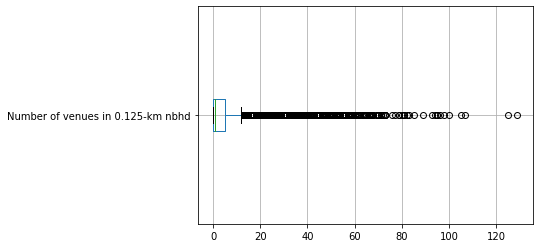

Processed and saved to  ./los-angeles/num_venues_0.125-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


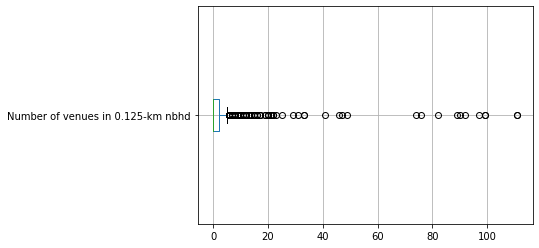

Processed and saved to  ./asheville/num_venues_0.125-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


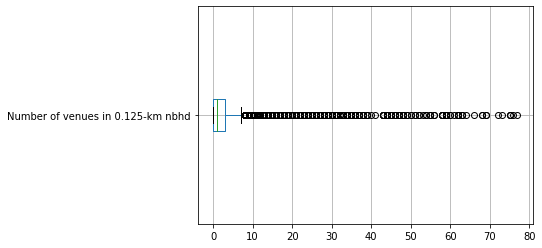

Processed and saved to  ./austin/num_venues_0.125-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


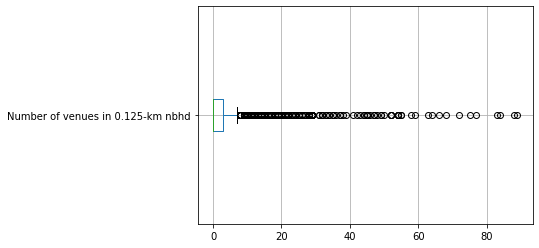

Processed and saved to  ./nashville/num_venues_0.125-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


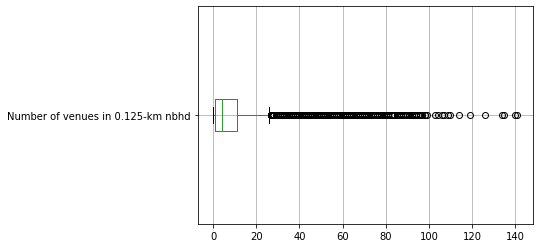

Processed and saved to  ./new-orleans/num_venues_0.125-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


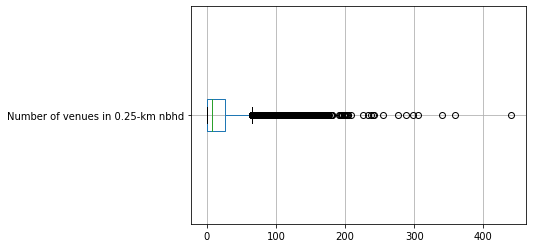

Processed and saved to  ./los-angeles/num_venues_0.25-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


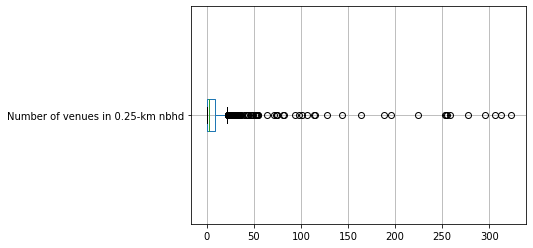

Processed and saved to  ./asheville/num_venues_0.25-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


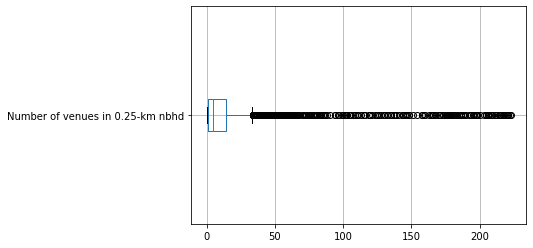

Processed and saved to  ./austin/num_venues_0.25-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


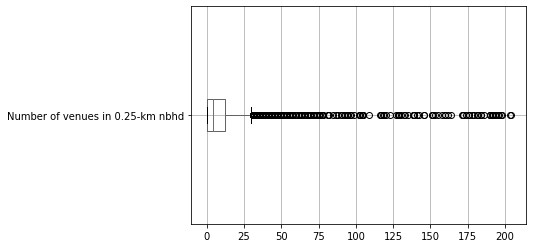

Processed and saved to  ./nashville/num_venues_0.25-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


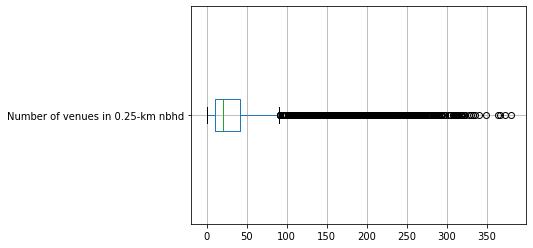

Processed and saved to  ./new-orleans/num_venues_0.25-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


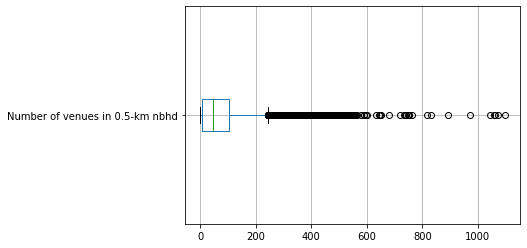

Processed and saved to  ./los-angeles/num_venues_0.5-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


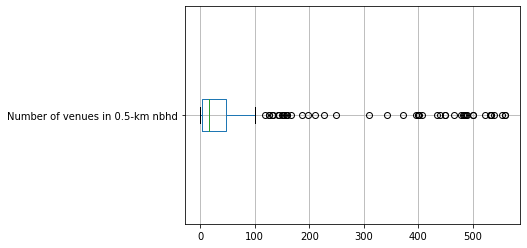

Processed and saved to  ./asheville/num_venues_0.5-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


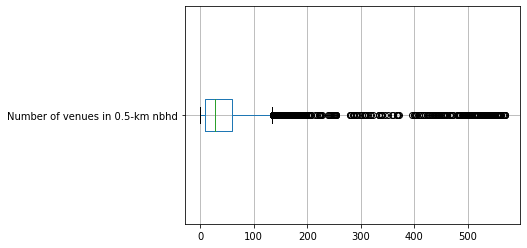

Processed and saved to  ./austin/num_venues_0.5-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


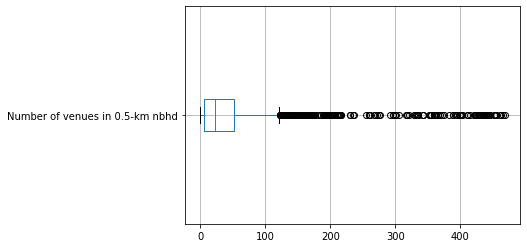

Processed and saved to  ./nashville/num_venues_0.5-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


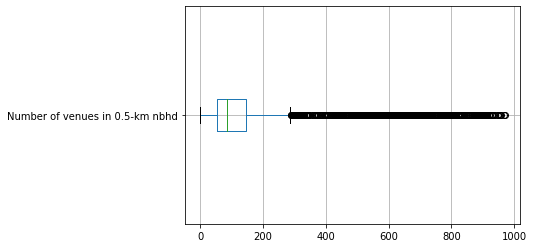

Processed and saved to  ./new-orleans/num_venues_0.5-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


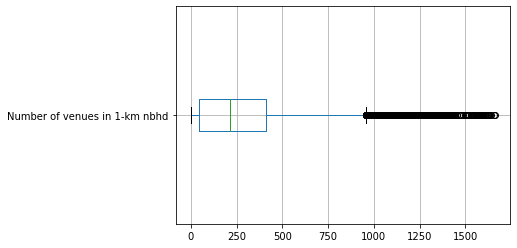

Processed and saved to  ./los-angeles/num_venues_1-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


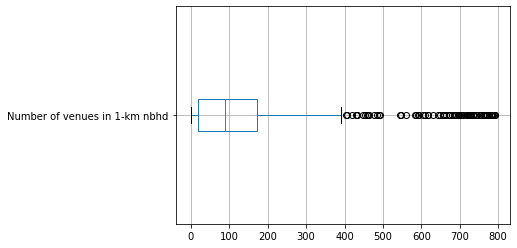

Processed and saved to  ./asheville/num_venues_1-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


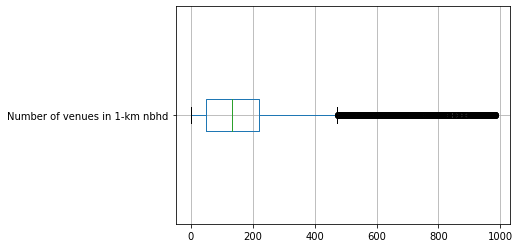

Processed and saved to  ./austin/num_venues_1-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


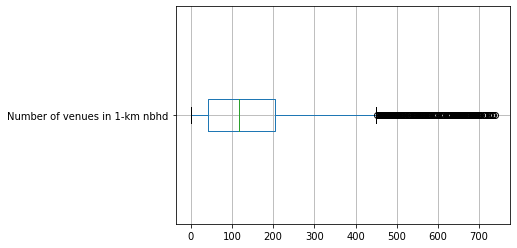

Processed and saved to  ./nashville/num_venues_1-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


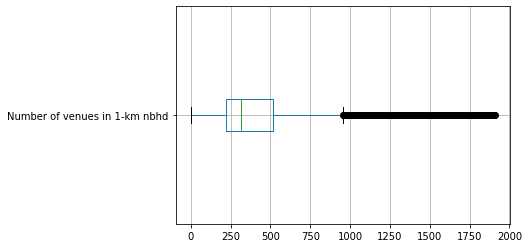

Processed and saved to  ./new-orleans/num_venues_1-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


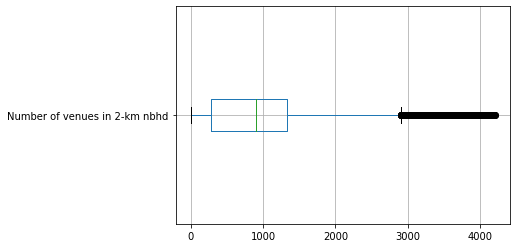

Processed and saved to  ./los-angeles/num_venues_2-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


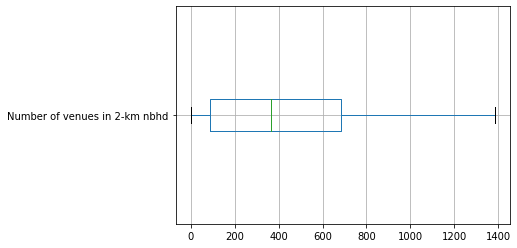

Processed and saved to  ./asheville/num_venues_2-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


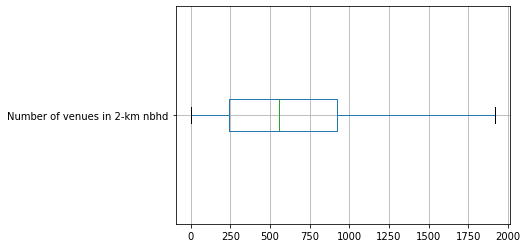

Processed and saved to  ./austin/num_venues_2-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


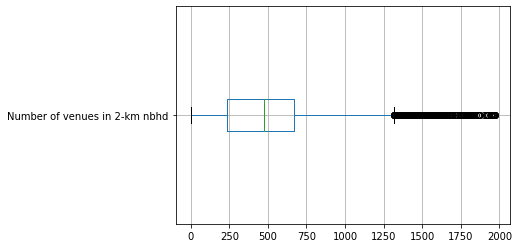

Processed and saved to  ./nashville/num_venues_2-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


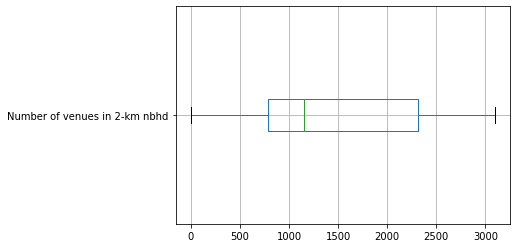

Processed and saved to  ./new-orleans/num_venues_2-km_nbhd.csv
In los-angeles: 31155 listings, 66492 venues
Done finding the nbhd


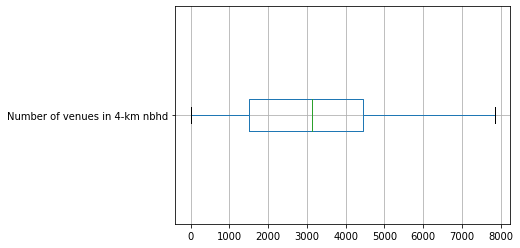

Processed and saved to  ./los-angeles/num_venues_4-km_nbhd.csv
In asheville: 864 listings, 6436 venues
Done finding the nbhd


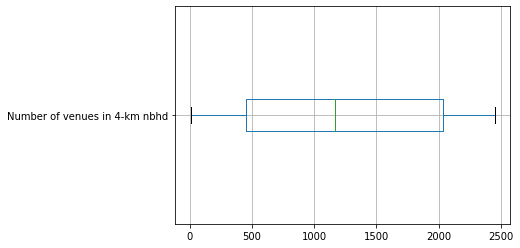

Processed and saved to  ./asheville/num_venues_4-km_nbhd.csv
In austin: 9658 listings, 18708 venues
Done finding the nbhd


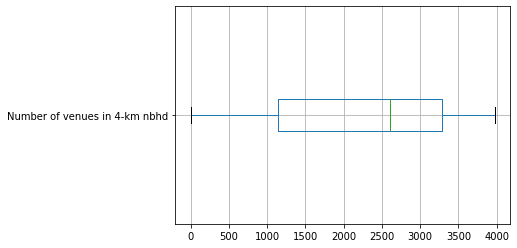

Processed and saved to  ./austin/num_venues_4-km_nbhd.csv
In nashville: 3277 listings, 10491 venues
Done finding the nbhd


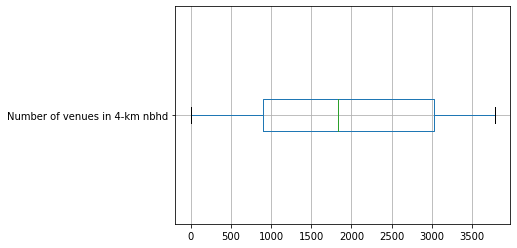

Processed and saved to  ./nashville/num_venues_4-km_nbhd.csv
In new-orleans: 5305 listings, 18880 venues
Done finding the nbhd


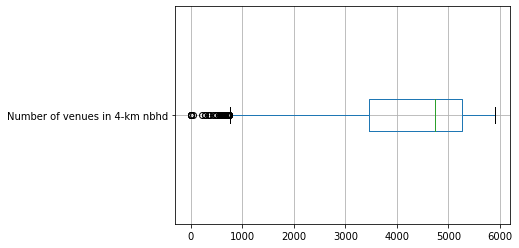

Processed and saved to  ./new-orleans/num_venues_4-km_nbhd.csv


In [22]:

listings_nbhd_allCity={}
for r in [0.125,0.25,0.5,1,2,4]:
  for region in regions:
    df=countVenuesInNbhd(r,
                        region,
                        df_listings_perCity[region],
                        df_venues_onehot_perCity[region])
    df_listings_perCity[region]=df
    listings_nbhd_allCity[region]=df
  df_listings_nbhd_all=pd.concat(listings_nbhd_allCity).set_index('listing_id')
  df_listings_nbhd_all.to_csv(f'listings_{r}-km_nbhd_listings.csv')


In [23]:
!!zip listings_nbhd_listings.zip *nbhd_listings.csv

['  adding: listings_0.125-km_nbhd_listings.csv (deflated 61%)',
 '  adding: listings_0.25-km_nbhd_listings.csv (deflated 61%)',
 '  adding: listings_0.5-km_nbhd_listings.csv (deflated 61%)',
 '  adding: listings_1-km_nbhd_listings.csv (deflated 61%)',
 '  adding: listings_2-km_nbhd_listings.csv (deflated 61%)',
 '  adding: listings_4-km_nbhd_listings.csv (deflated 60%)']

In [24]:
df_listings_nbhd_all.to_csv(f'counts_in_nbhd.csv')

In [25]:
df_listings_raw=pd.read_csv('Datasets/listings.csv')

In [26]:
n_listings=df_listings_raw[['id','host_id']].groupby('host_id').count().rename(columns={'id':'multi-listings-count'})

In [27]:
df_multi_listings=df_listings_raw.set_index('host_id').join(n_listings).set_index('id')
df_multi_listings.to_csv('multi-listings.csv')

In [28]:
df_multi_listings['is multi-listings']=(df_multi_listings['multi-listings-count']>1).astype(float)
df_multi_listings[['multi-listings-count','is multi-listings']]

,multi-listings-count,is multi-listings
id,,
11587254,1,0.0
11570194,1,0.0
8060457,1,0.0
109,1,0.0
344,1,0.0
...,...,...
18873012,1,0.0
18959047,2,1.0
18915100,2,1.0


In [29]:
df_join=df_listings_nbhd_all.join(df_multi_listings[['multi-listings-count','is multi-listings']])
df_join.to_csv('nbhd_multi-listings.csv')
df_join

,occupancy rate,price,latitude,longitude,neighbourhood,metropolitan,listings_0.125-km_nbhd,listings_0.25-km_nbhd,listings_0.5-km_nbhd,listings_1-km_nbhd,listings_2-km_nbhd,listings_4-km_nbhd,venues_0.125-km_nbhd,venues_0.25-km_nbhd,venues_0.5-km_nbhd,venues_1-km_nbhd,venues_2-km_nbhd,venues_4-km_nbhd,multi-listings-count,is multi-listings
109,0.000000,NaN,33.982095,-118.384935,Culver City,los-angeles,4,12,19,58,142,683,1,9,39,377,849,2455,1,0.0
344,0.000000,NaN,34.165616,-118.334582,Burbank,los-angeles,1,3,7,34,122,697,0,0,7,84,364,1799,1,0.0
941,0.400248,106.558666,34.071556,-118.350786,Fairfax,los-angeles,3,26,165,569,1389,5540,0,6,31,277,1079,6404,1,0.0
1078,0.072527,104.033333,30.301231,-97.736736,78705,austin,5,25,83,248,876,2822,0,22,71,326,960,3330,3,1.0
2265,0.167430,210.087719,30.277500,-97.713975,78702,austin,6,32,99,337,1003,3260,2,4,32,196,744,3612,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19034190,0.341154,154.218056,29.974433,-90.068229,Seventh Ward,new-orleans,10,20,99,490,1677,3275,2,11,75,252,1724,4954,2,1.0
19035492,0.338941,67.904790,29.972830,-90.056200,St. Roch,new-orleans,7,22,133,555,1487,3024,5,27,102,380,1553,4571,2,1.0
19035679,0.982117,91.751668,30.017616,-89.993928,Plum Orchard,new-orleans,1,2,2,3,6,37,1,1,14,81,239,667,1,0.0
19037230,0.257369,90.486667,29.923243,-90.118153,Audubon,new-orleans,3,7,37,108,369,1420,1,30,94,255,705,2407,1,0.0


In [30]:
df_join_clean=df_join[df_join['venues_4-km_nbhd']>0] # clean listings that has no venues data in its nbhd

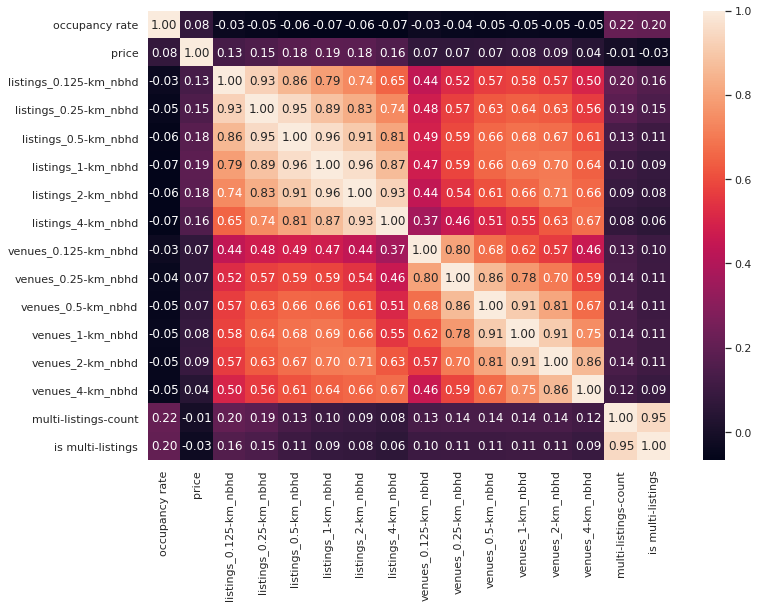

In [31]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

colToLook=['occupancy rate', 'price', 'neighbourhood', 'listings_0.125-km_nbhd', 'listings_0.25-km_nbhd',
       'listings_0.5-km_nbhd', 'listings_1-km_nbhd', 'listings_2-km_nbhd',
       'listings_4-km_nbhd', 'venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd', 'multi-listings-count','is multi-listings']
corr=df_join_clean[colToLook].corr(method ='spearman')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True,fmt='.2f')

In [32]:
listings_col=[col for col in df_join.columns if 'listings_' in col]
venues_col=[col for col in df_join.columns if 'venues_' in col]

In [33]:
df_disjoin_nbhd=df_join_clean.copy()

In [34]:
df_=df_join_clean
df_disjoin_nbhd[listings_col[1:]]=df_[listings_col[1:]].values-df_[listings_col[:-1]].values
df_disjoin_nbhd[venues_col[1:]]=df_[venues_col[1:]].values-df_[venues_col[:-1]].values

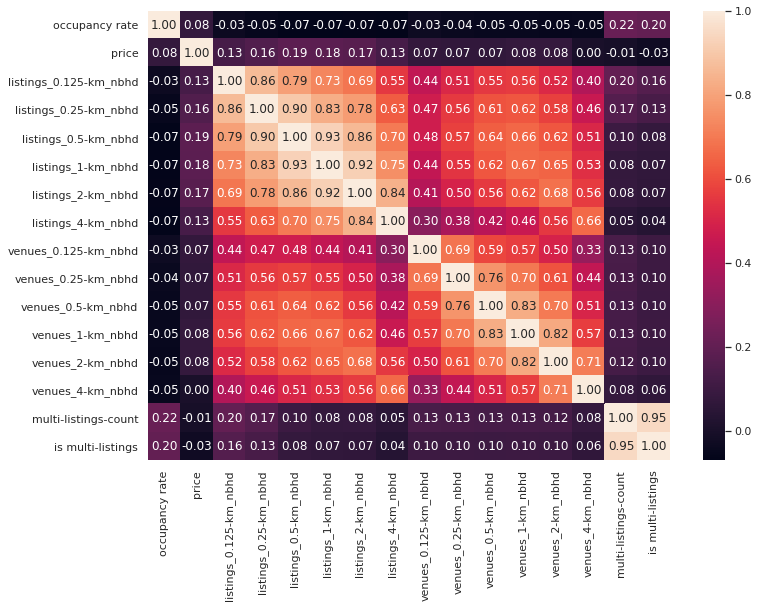

In [35]:
colToLook=['occupancy rate', 'price', 'neighbourhood', 'listings_0.125-km_nbhd', 'listings_0.25-km_nbhd',
       'listings_0.5-km_nbhd', 'listings_1-km_nbhd', 'listings_2-km_nbhd',
       'listings_4-km_nbhd', 'venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd', 'multi-listings-count','is multi-listings']
corr=df_disjoin_nbhd[colToLook].corr(method ='spearman')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True,fmt='.2f')
plt.savefig('correlation.png',bbox_inches='tight')

In [38]:
df.corr(method ='pearson').loc[['listings_0.125-km_nbhd', 'listings_0.25-km_nbhd',
       'listings_0.5-km_nbhd', 'listings_1-km_nbhd', 'listings_2-km_nbhd',
       'listings_4-km_nbhd'],['venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd']]

,venues_0.125-km_nbhd,venues_0.25-km_nbhd,venues_0.5-km_nbhd,venues_1-km_nbhd,venues_2-km_nbhd,venues_4-km_nbhd
listings_0.125-km_nbhd,0.571516,0.604879,0.610400,0.657316,0.601662,0.465052
listings_0.25-km_nbhd,0.613984,0.658788,0.679185,0.734709,0.685373,0.523339
listings_0.5-km_nbhd,0.608088,0.667480,0.713053,0.786679,0.782049,0.603680
listings_1-km_nbhd,0.434446,0.482169,0.536933,0.667136,0.820468,0.699358
listings_2-km_nbhd,0.389060,0.430243,0.481410,0.614733,0.874773,0.790438
listings_4-km_nbhd,0.439071,0.482840,0.534623,0.637170,0.817143,0.933330


In [61]:
def plotHeatMap_small(df):
  colToLook=['occupancy rate', 'price', 'neighbourhood', 'listings_0.125-km_nbhd', 'listings_0.25-km_nbhd',
       'listings_0.5-km_nbhd', 'listings_1-km_nbhd', 'listings_2-km_nbhd',
       'listings_4-km_nbhd', 'venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd', 'multi-listings-count','is multi-listings']
  listings_col=['listings_0.125-km_nbhd', 'listings_0.25-km_nbhd',
       'listings_0.5-km_nbhd', 'listings_1-km_nbhd', 'listings_2-km_nbhd',
       'listings_4-km_nbhd']
  venues_col=['venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd']
  corr=df[colToLook].corr(method ='spearman')
  corr=corr.loc[listings_col,venues_col]

  sns.heatmap(corr, 
          xticklabels=[ label[7:-5] for label in corr.columns],
          yticklabels=[ label[9:-5] for label in corr.index],annot=True,fmt='.2f',
          vmax=1,          
          vmin=0,          
          )

In [62]:
df_disjoin_nbhd.keys()

Index(['occupancy rate', 'price', 'latitude', 'longitude', 'neighbourhood',
       'metropolitan', 'listings_0.125-km_nbhd', 'listings_0.25-km_nbhd',
       'listings_0.5-km_nbhd', 'listings_1-km_nbhd', 'listings_2-km_nbhd',
       'listings_4-km_nbhd', 'venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd', 'multi-listings-count', 'is multi-listings'],
      dtype='object')

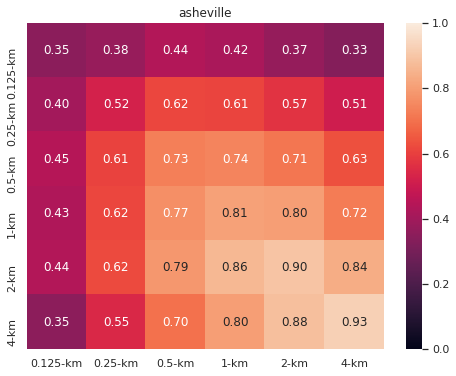

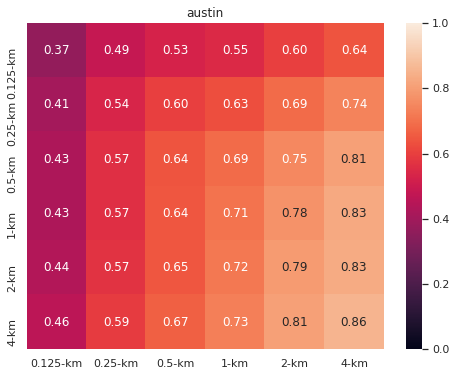

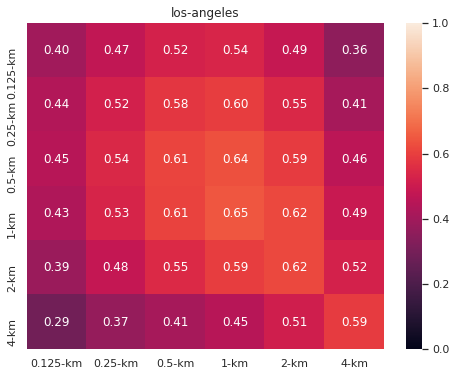

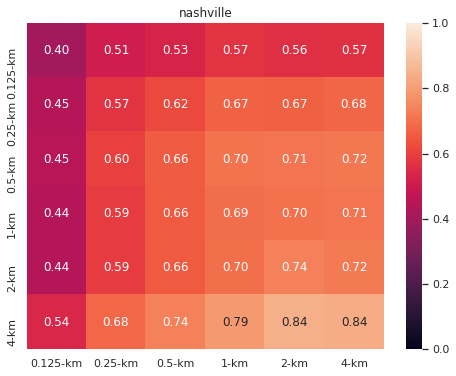

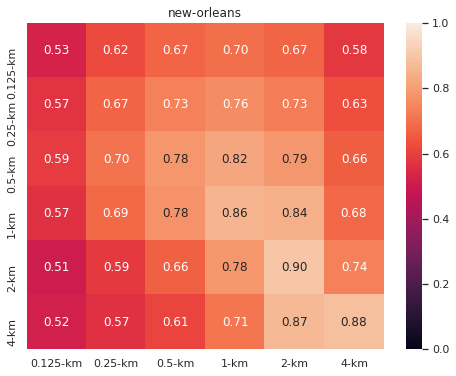

In [63]:
sns.set(rc={'figure.figsize':(8,6)})

for (key,df) in df_join_clean.groupby('metropolitan'):

  plotHeatMap_small(df)
  plt.title(key)
  plt.show()

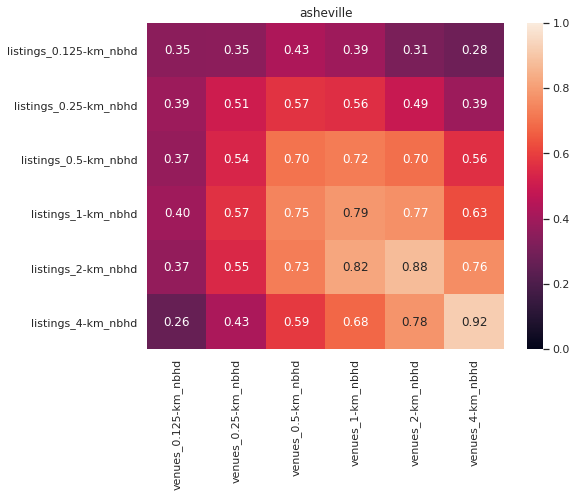

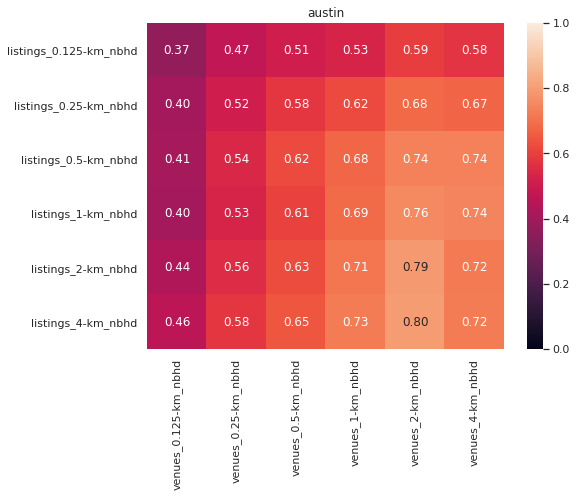

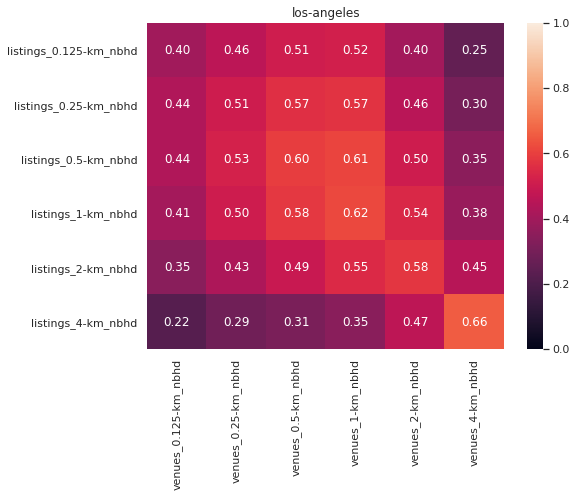

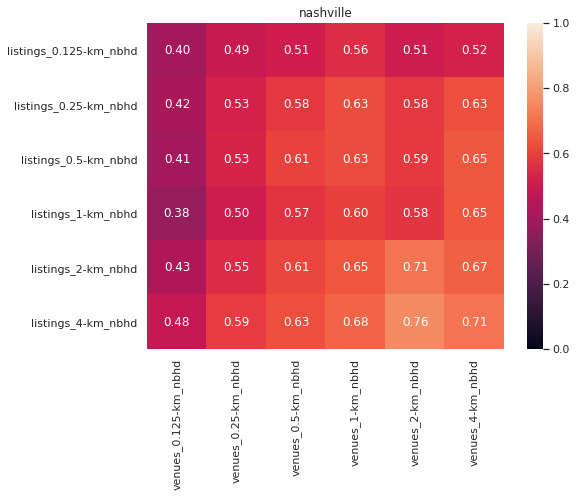

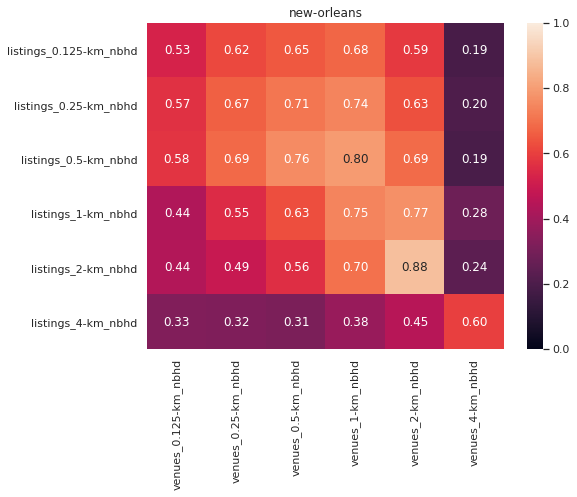

In [47]:
for (key,df) in df_disjoin_nbhd.groupby('metropolitan'):

  plotHeatMap_small(df)
  plt.title(key)
  plt.show()

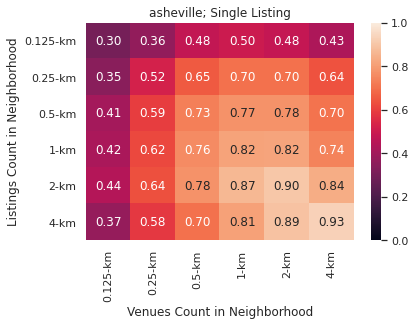

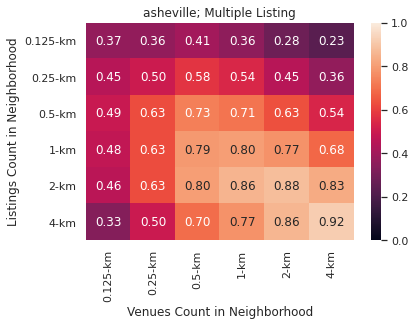

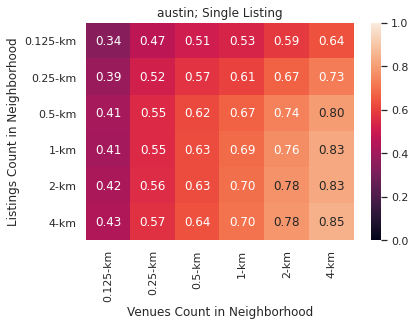

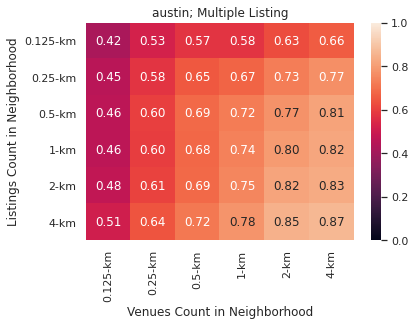

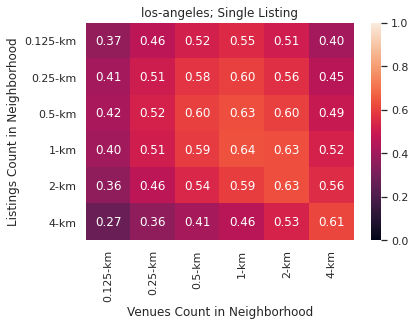

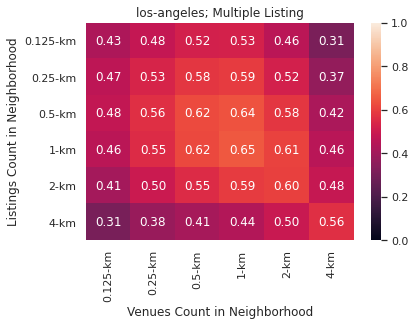

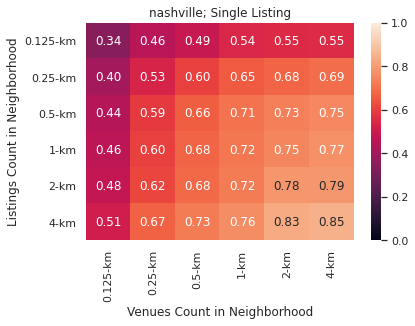

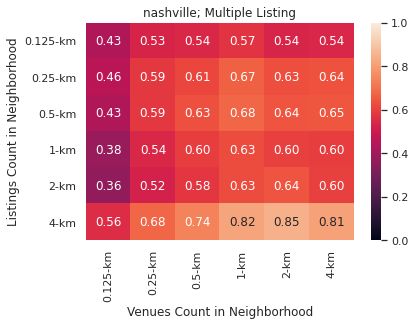

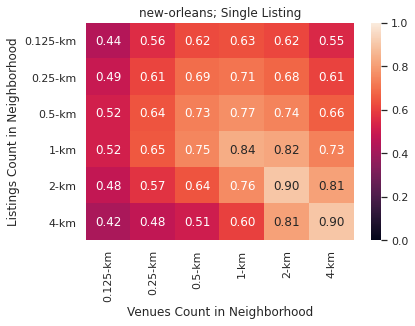

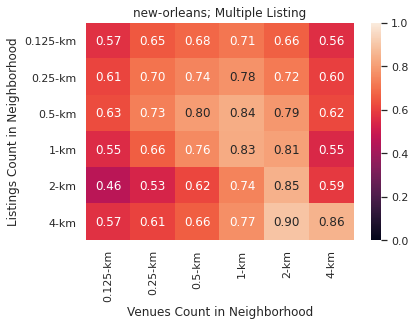

In [65]:
sns.set(rc={'figure.figsize':(6,4)})

map_={0:'Single Listing',1:'Multiple Listing'}
for (key,df) in df_join_clean.groupby(['metropolitan','is multi-listings']):

  plotHeatMap_small(df)
  
  plt.title(f'{key[0]}; {map_[key[1]]}')
  plt.xlabel('Venues Count in Neighborhood')
  plt.ylabel('Listings Count in Neighborhood')
  plt.savefig(f'{key[0]}_{map_[key[1]]}.png')
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [208]:
df_renamed=df_join_clean.copy()
df_renamed['is multi-listings']=df_join_clean['is multi-listings'].replace({0:'single',1:'mulitple'})

venues_col=['venues_0.125-km_nbhd', 'venues_0.25-km_nbhd',
       'venues_0.5-km_nbhd', 'venues_1-km_nbhd', 'venues_2-km_nbhd',
       'venues_4-km_nbhd']

In [214]:
melted=(df_renamed[venues_col].unstack().reset_index().rename(columns={'level_0':'Distance to listing','level_1':'id',0:'Counts'}).set_index('id'))
melted=melted.join((df_renamed[['is multi-listings']]))
melted['Distance to listing']=melted['Distance to listing'].apply(lambda x: x[7:-5])
melted

,Distance to listing,Counts,is multi-listings
109,0.125-km,1,single
109,0.25-km,9,single
109,0.5-km,39,single
109,1-km,377,single
109,2-km,849,single
...,...,...,...
19038571,0.25-km,175,single
19038571,0.5-km,625,single
19038571,1-km,1682,single
19038571,2-km,2988,single


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


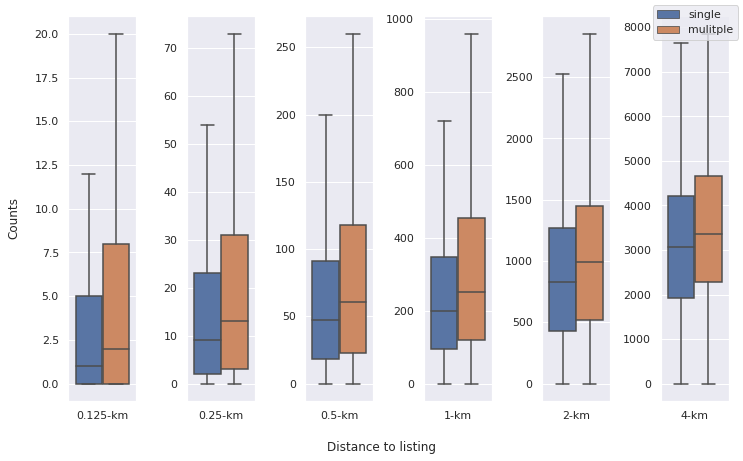

In [212]:
sns.set(rc={'figure.figsize':(2,6)})
fig, axes= plt.subplots(1,6, figsize=(10,6))
i=0
for (key,df) in melted.groupby('Distance to listing'):
  g=sns.boxplot(data=df, x='Distance to listing',y='Counts',hue='is multi-listings',showfliers=False,ax=axes[i])
  
  axes[i].legend([],[], frameon=False)
  if i==5:
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, labels, loc='best')

  axes[i].set_xlabel('')
  axes[i].set_ylabel('')
  i+=1
fig.text(0.5, -0.04, 'Distance to listing', ha='center')
fig.text(-0.02, 0.5, 'Counts', va='center', rotation='vertical')
fig.tight_layout()
plt.savefig('counts_plot.png',bbox_inches="tight")
plt.show()

In [217]:
df_renamed.groupby('metropolitan')

In [238]:
df_renamed=df_renamed[df_renamed['venues_4-km_nbhd']>0]

In [239]:
melted=(df_renamed[venues_col].unstack().reset_index().rename(columns={'level_0':'Distance to listing','level_1':'id',0:'Counts'}).set_index('id'))
melted=melted.join((df_renamed[['is multi-listings','metropolitan']]))
melted['Distance to listing']=melted['Distance to listing'].apply(lambda x: x[7:-5])
melted

,Distance to listing,Counts,is multi-listings,metropolitan
109,0.125-km,1,single,los-angeles
109,0.25-km,9,single,los-angeles
109,0.5-km,39,single,los-angeles
109,1-km,377,single,los-angeles
109,2-km,849,single,los-angeles
...,...,...,...,...
19038571,0.25-km,175,single,new-orleans
19038571,0.5-km,625,single,new-orleans
19038571,1-km,1682,single,new-orleans
19038571,2-km,2988,single,new-orleans


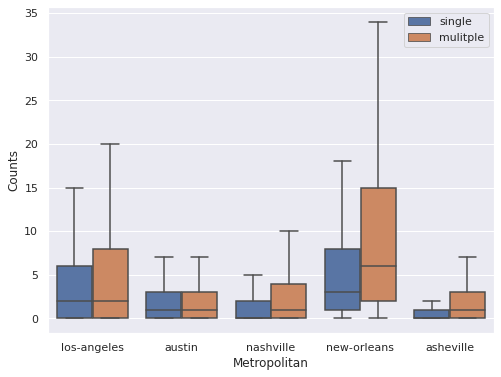

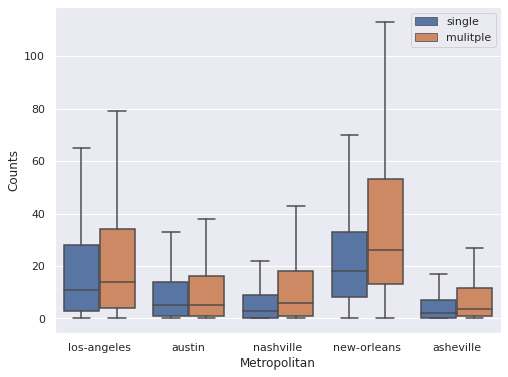

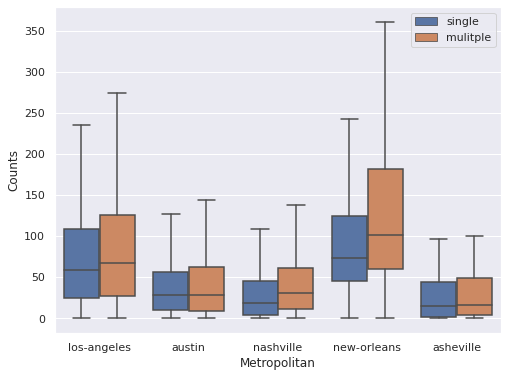

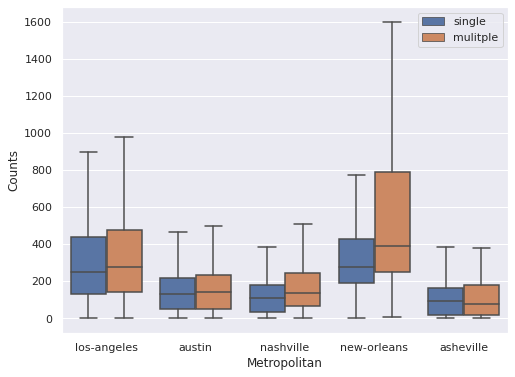

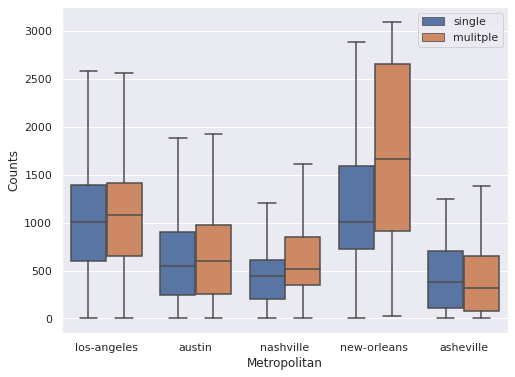

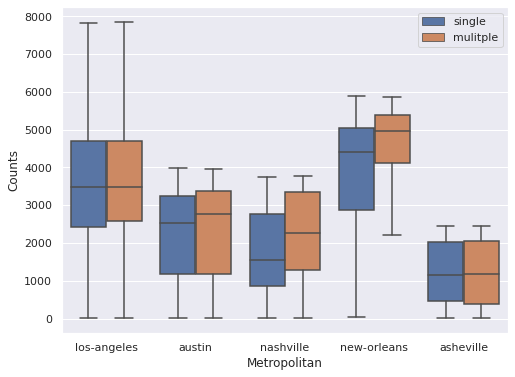

In [242]:
sns.set(rc={'figure.figsize':(8,6)})
# fig, axes= plt.subplots(1,6, figsize=(10,6))
for (i,df) in melted.groupby('Distance to listing'):

  g= sns.boxplot(data=df, x='metropolitan',y='Counts',hue='is multi-listings',showfliers=False)

  fig.tight_layout()
  # plt.title(f'Number of venues in {i} radius circle of the listing')
  g.legend_.set_title(None)
  plt.xlabel('Metropolitan')
  plt.savefig(f'counts_plot_metro_{i}.png',bbox_inches="tight")
  plt.show()

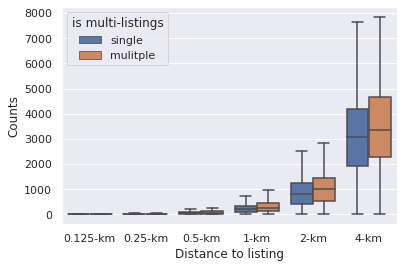

In [117]:
sns.boxplot(data=melted, x='Distance to listing',y='Counts',hue='is multi-listings',showfliers=False)

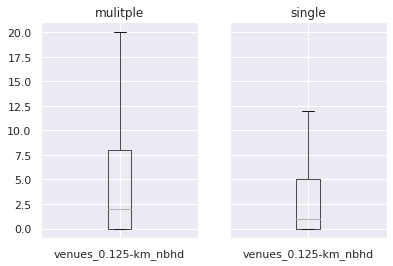

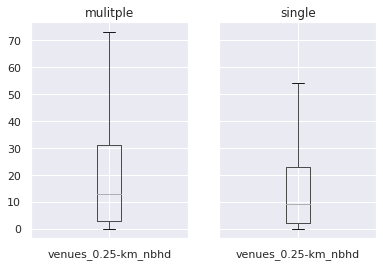

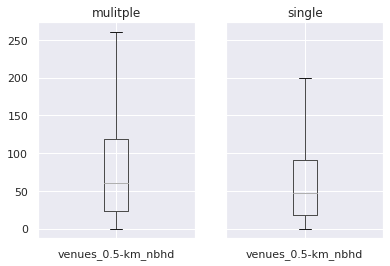

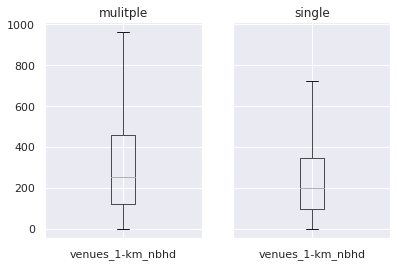

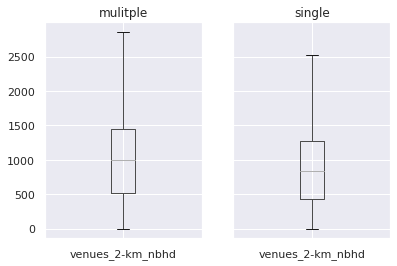

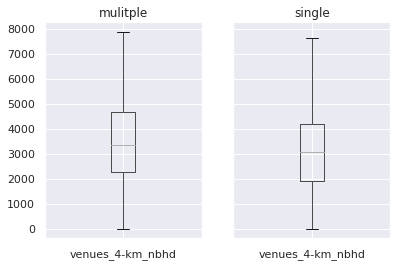

In [67]:


for col in venues_col:
  df_renamed.groupby('is multi-listings').boxplot(column=col,showfliers=False)

In [183]:
from scipy.stats import mannwhitneyu, ttest_ind

In [184]:
X,Y=dict([*df_renamed.groupby('is multi-listings')]).items()

In [244]:
venues_col

['venues_0.125-km_nbhd',
 'venues_0.25-km_nbhd',
 'venues_0.5-km_nbhd',
 'venues_1-km_nbhd',
 'venues_2-km_nbhd',
 'venues_4-km_nbhd']

In [197]:
df_to=[]
for col in venues_col:
  res=mannwhitneyu(X[1][col],Y[1][col],alternative='greater')
  df_to.append([col[7:-5],res.statistic,res.pvalue])
  print(f'{col[7:-5]},{res.statistic},{res.pvalue:.2f}')

0.125-km,279102831.5,0.00
0.25-km,280704022.0,0.00
0.5-km,280632771.0,0.00
1-km,281207334.0,0.00
2-km,282067569.0,0.00
4-km,276939643.5,0.00


In [205]:
pd.DataFrame(df_to).round(0)

,0,1,2
0,0.125-km,279102832.0,0.0
1,0.25-km,280704022.0,0.0
2,0.5-km,280632771.0,0.0
3,1-km,281207334.0,0.0
4,2-km,282067569.0,0.0
5,4-km,276939644.0,0.0


In [254]:
[*df_renamed.groupby(['metropolitan'])][0][1]

,occupancy rate,price,latitude,longitude,neighbourhood,metropolitan,listings_0.125-km_nbhd,listings_0.25-km_nbhd,listings_0.5-km_nbhd,listings_1-km_nbhd,listings_2-km_nbhd,listings_4-km_nbhd,venues_0.125-km_nbhd,venues_0.25-km_nbhd,venues_0.5-km_nbhd,venues_1-km_nbhd,venues_2-km_nbhd,venues_4-km_nbhd,multi-listings-count,is multi-listings
38585,0.965035,50.000000,35.651459,-82.627918,28804,asheville,1,1,1,1,2,13,1,1,2,3,10,66,1,single
67870,0.981051,71.366638,35.553707,-82.626297,28806,asheville,2,3,3,5,13,108,0,1,4,12,128,593,2,mulitple
80331,0.986014,119.197408,35.569150,-82.549715,28803,asheville,2,4,4,18,62,306,7,8,37,191,465,2247,4,mulitple
80905,0.934642,338.055532,35.597006,-82.552370,28801,asheville,6,15,22,86,199,393,82,196,485,777,1162,2366,7,mulitple
136547,0.831311,99.000000,35.577443,-82.607318,28806,asheville,1,3,12,39,130,226,0,6,30,126,380,974,1,single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12426308,1.000000,2293.248418,35.603897,-82.577101,28801,asheville,2,5,6,15,113,429,2,6,10,49,309,2015,4,mulitple
12430937,0.899628,75.000000,35.574437,-82.535964,28803,asheville,2,5,12,31,69,286,0,3,18,145,693,2181,1,single
12433546,0.083602,118.888889,35.587217,-82.579266,28806,asheville,1,5,9,24,163,436,1,2,32,140,616,2034,1,single
12468460,0.427771,62.235247,35.569837,-82.593897,28806,asheville,1,4,11,48,140,243,2,5,10,75,411,1027,1,single


In [259]:
df=[*df_renamed.groupby(['metropolitan'])][0][1]
X,Y=dict([*df.groupby('is multi-listings')]).items()

In [269]:
df_to=[]
for col in venues_col:
  for (key,df) in df_renamed.groupby(['metropolitan']):
    X,Y=dict([*df.groupby('is multi-listings')]).items()

    res=mannwhitneyu(X[1][col],Y[1][col],alternative='greater')
    df_to.append([col[7:-5],key,res.pvalue])
    print(f'{col[7:-5]}, {key},{res.pvalue:.2f}')

0.125-km, asheville,0.00
0.125-km, austin,0.00
0.125-km, los-angeles,0.00
0.125-km, nashville,0.00
0.125-km, new-orleans,0.00
0.25-km, asheville,0.00
0.25-km, austin,0.01
0.25-km, los-angeles,0.00
0.25-km, nashville,0.00
0.25-km, new-orleans,0.00
0.5-km, asheville,0.04
0.5-km, austin,0.01
0.5-km, los-angeles,0.00
0.5-km, nashville,0.00
0.5-km, new-orleans,0.00
1-km, asheville,0.46
1-km, austin,0.00
1-km, los-angeles,0.00
1-km, nashville,0.00
1-km, new-orleans,0.00
2-km, asheville,0.77
2-km, austin,0.00
2-km, los-angeles,0.00
2-km, nashville,0.00
2-km, new-orleans,0.00
4-km, asheville,0.53
4-km, austin,0.00
4-km, los-angeles,0.01
4-km, nashville,0.00
4-km, new-orleans,0.00


In [279]:
pd.DataFrame(df_to).round(3).set_index([0,1]).unstack()

2                                         
1        asheville austin los-angeles nashville new-orleans
0                                                          
0.125-km     0.000  0.001       0.000       0.0         0.0
0.25-km      0.000  0.008       0.000       0.0         0.0
0.5-km       0.042  0.007       0.000       0.0         0.0
1-km         0.462  0.000       0.000       0.0         0.0
2-km         0.774  0.000       0.000       0.0         0.0
4-km         0.532  0.000       0.012       0.0         0.0

In [186]:
for col in venues_col:
  res=ttest_ind(X[1][col],Y[1][col])
  print(col,res)

venues_0.125-km_nbhd Ttest_indResult(statistic=21.430796097097648, pvalue=2.222897068392706e-101)
venues_0.25-km_nbhd Ttest_indResult(statistic=23.48098072205568, pvalue=3.4330856343967798e-121)
venues_0.5-km_nbhd Ttest_indResult(statistic=23.803972190435204, pvalue=1.7953933394815427e-124)
venues_1-km_nbhd Ttest_indResult(statistic=24.330371260123737, pvalue=6.497581943642442e-130)
venues_2-km_nbhd Ttest_indResult(statistic=23.920807270398736, pvalue=1.1387070186973748e-125)
venues_4-km_nbhd Ttest_indResult(statistic=18.844470703821283, pvalue=6.578559681226711e-79)


In [266]:
X[1][venues_col]

,venues_0.125-km_nbhd,venues_0.25-km_nbhd,venues_0.5-km_nbhd,venues_1-km_nbhd,venues_2-km_nbhd,venues_4-km_nbhd
1078,0,22,71,326,960,3330
2265,2,4,32,196,744,3612
2732,5,10,140,489,1321,3479
3021,0,1,2,16,143,3033
3152,2,5,10,98,585,1907
...,...,...,...,...,...,...
19013896,3,19,92,384,2176,4920
19016073,6,29,71,369,1725,4721
19032418,10,23,59,322,2466,5579
19034190,2,11,75,252,1724,4954


In [256]:
mannwhitneyu


<function scipy.stats.stats.mannwhitneyu>

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

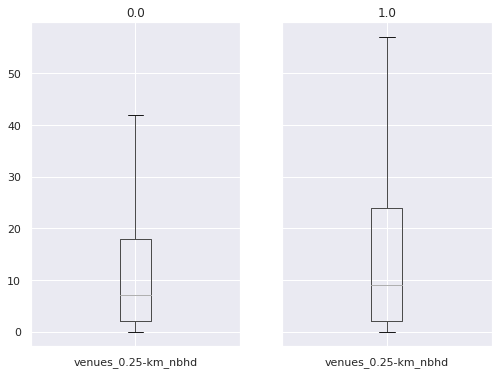

In [230]:
df_disjoin_nbhd.groupby('is multi-listings').boxplot(column=['venues_0.25-km_nbhd'],showfliers=False)

In [228]:
df_disjoin_nbhd_yoPlot=df_disjoin_nbhd.copy()

mask = df_disjoin_nbhd_yoPlot['venues_0.125-km_nbhd']>20
column_name = 'venues_0.125-km_nbhd'
df_disjoin_nbhd_yoPlot.loc[mask, column_name] = 21


is multi-listings
0.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

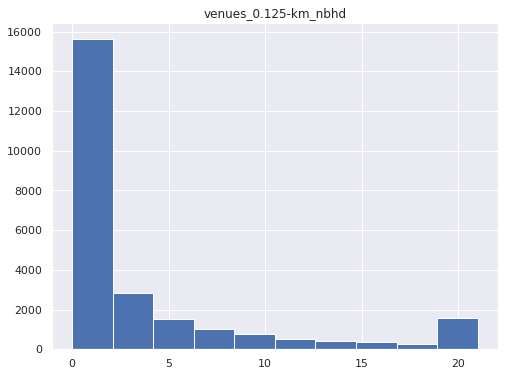

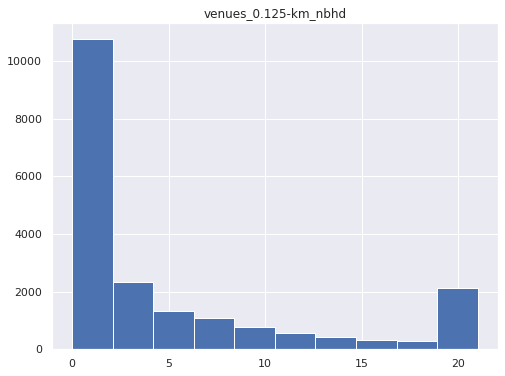

In [229]:
df_disjoin_nbhd_yoPlot.groupby('is multi-listings').hist(column=['venues_0.125-km_nbhd'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

neighbourhood
28704             AxesSubplot(0.125,0.125;0.775x0.755)
28715             AxesSubplot(0.125,0.125;0.775x0.755)
28732             AxesSubplot(0.125,0.125;0.775x0.755)
28801             AxesSubplot(0.125,0.125;0.775x0.755)
28803             AxesSubplot(0.125,0.125;0.775x0.755)
                                  ...                 
Willowbrook       AxesSubplot(0.125,0.125;0.775x0.755)
Wilmington        AxesSubplot(0.125,0.125;0.775x0.755)
Windsor Square    AxesSubplot(0.125,0.125;0.775x0.755)
Winnetka          AxesSubplot(0.125,0.125;0.775x0.755)
Woodland Hills    AxesSubplot(0.125,0.125;0.775x0.755)
Length: 405, dtype: object

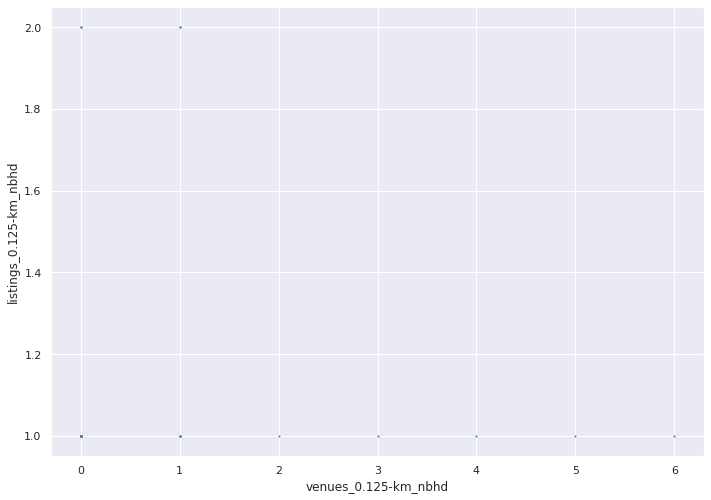

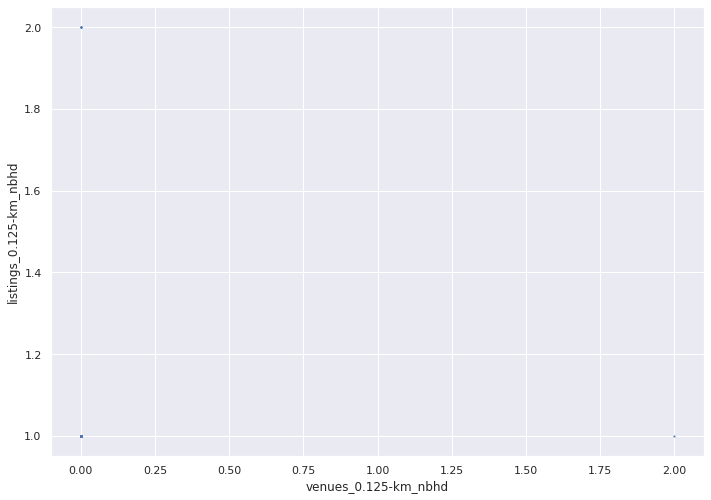

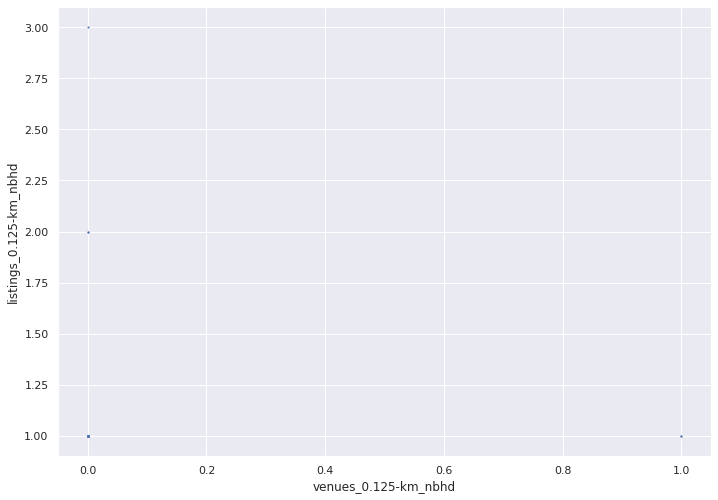

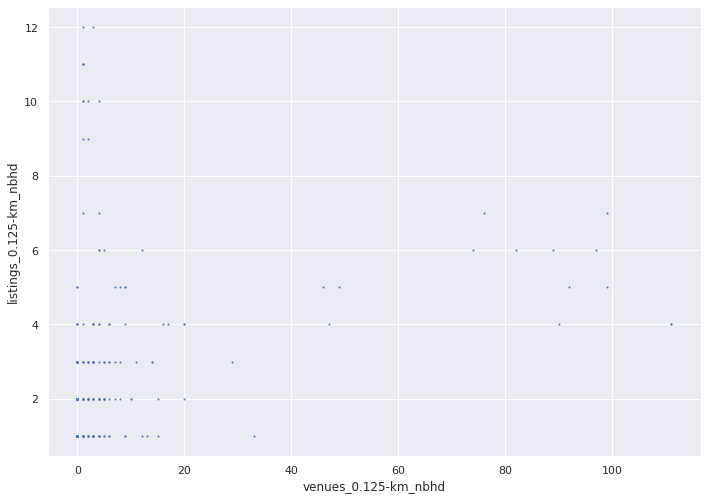

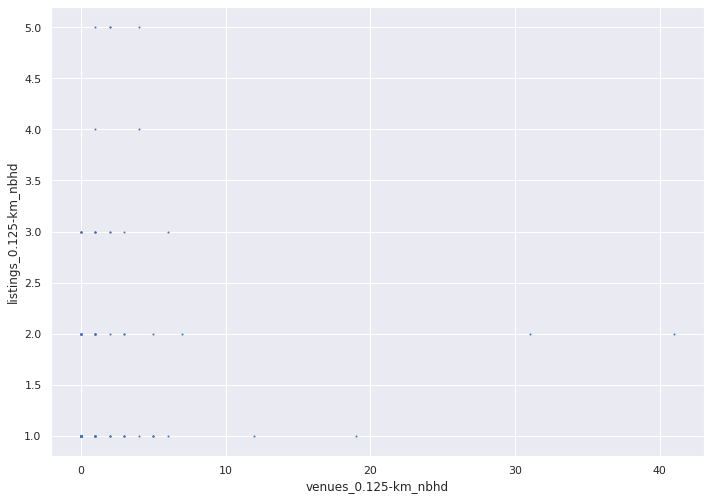

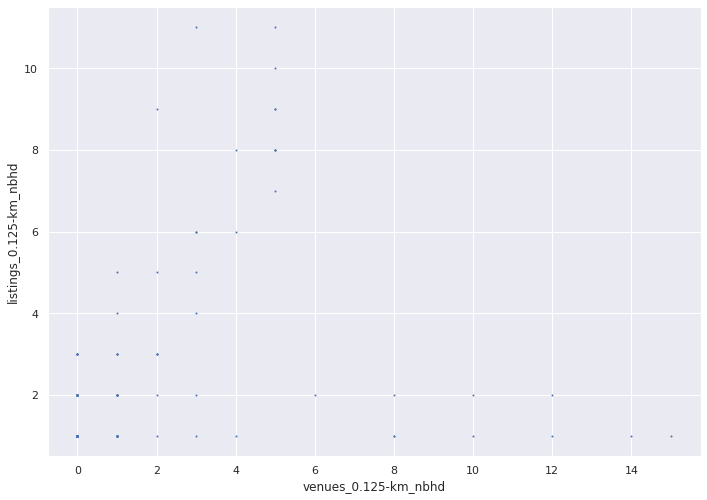

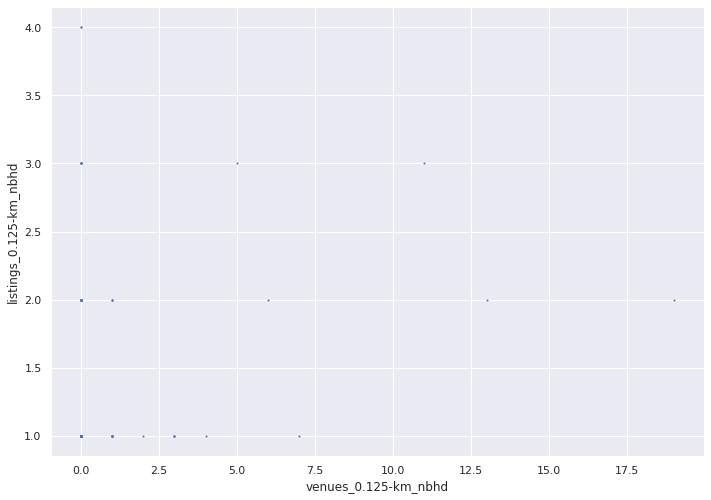

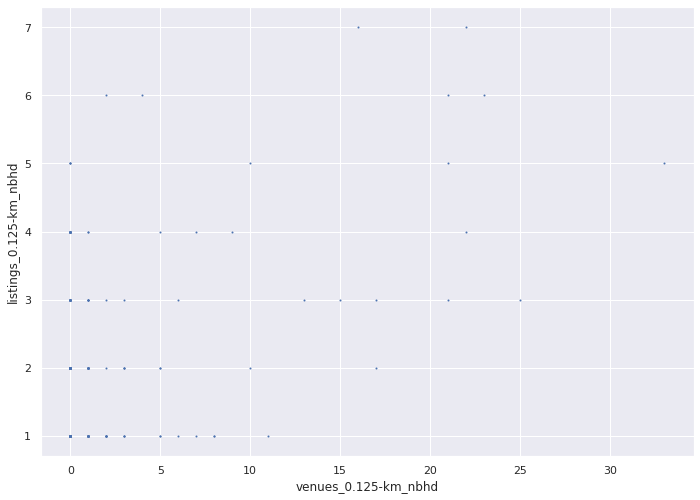

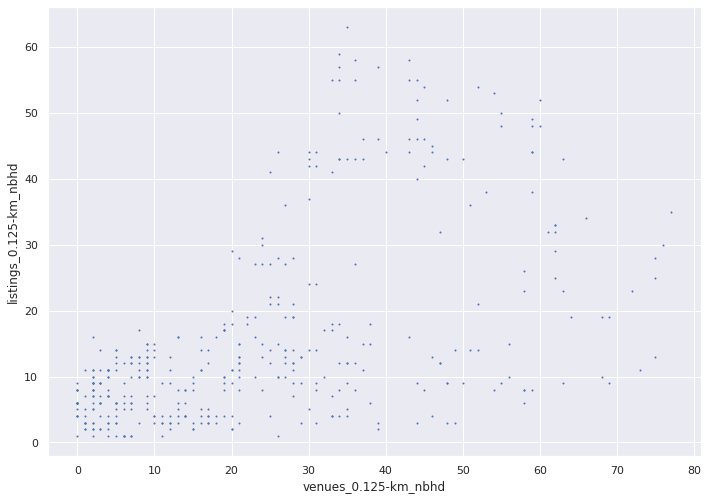

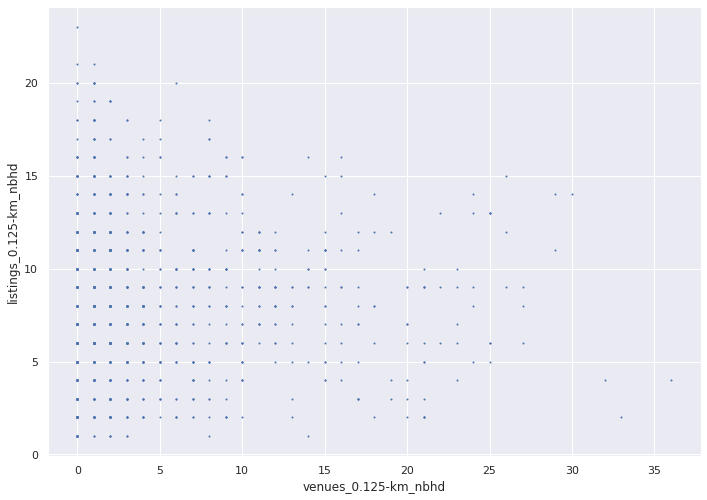

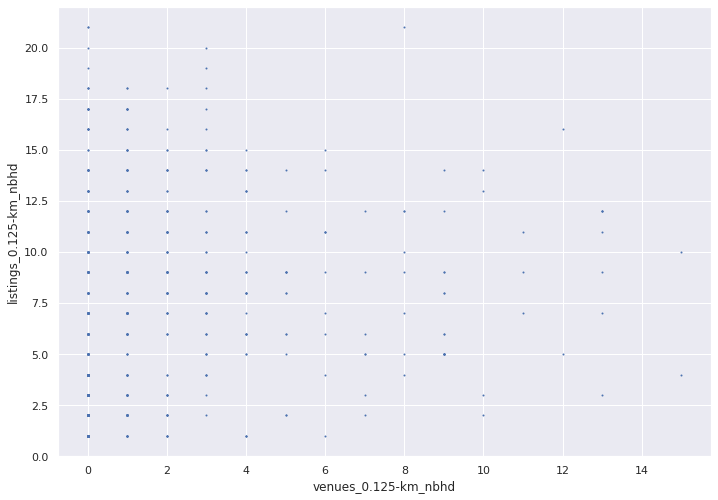

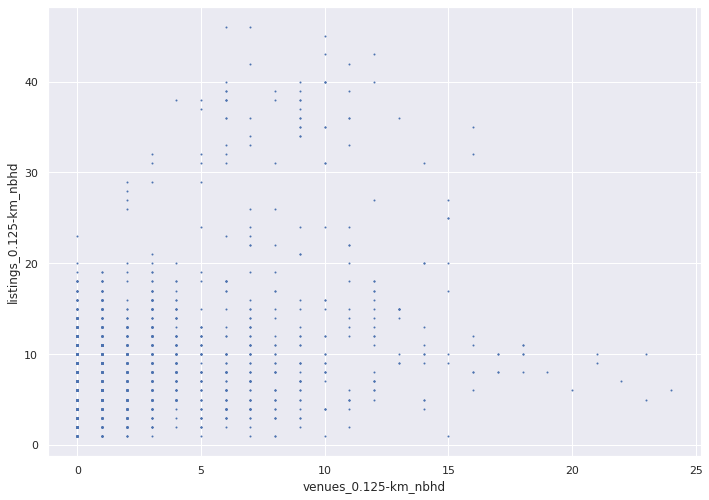

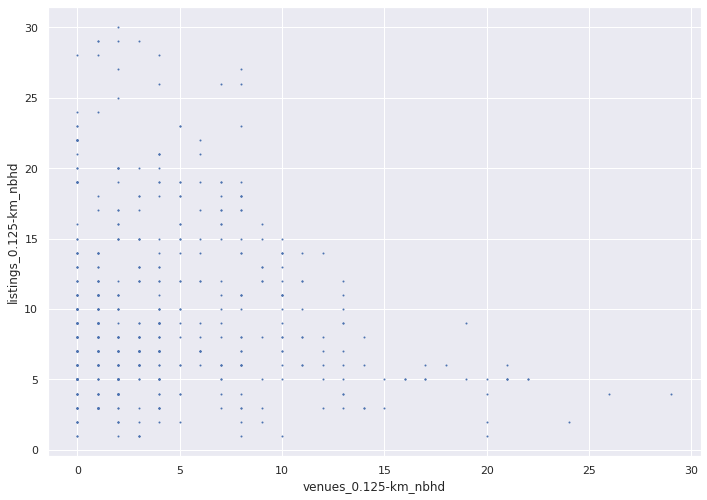

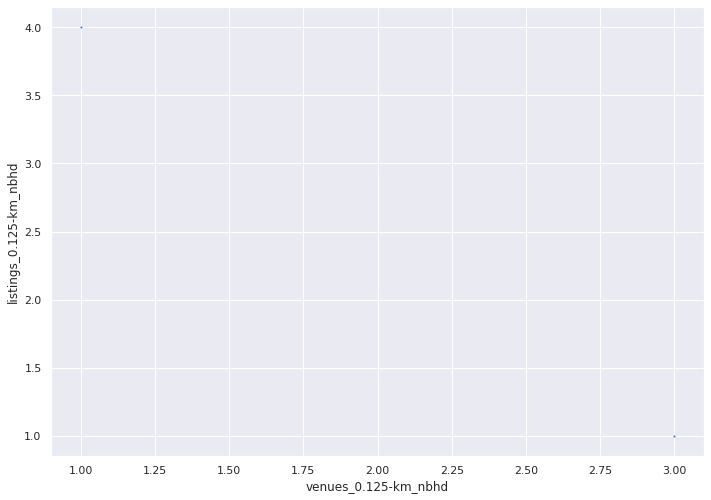

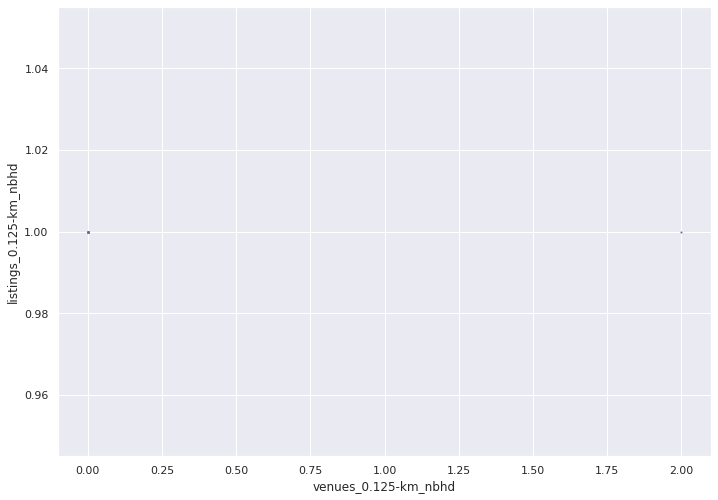

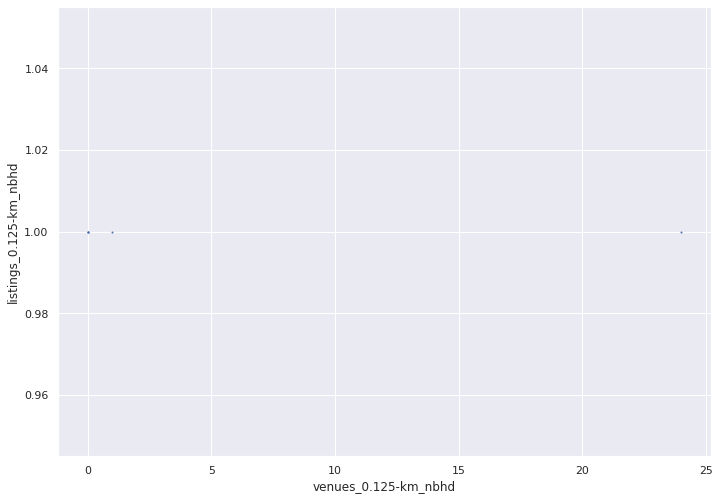

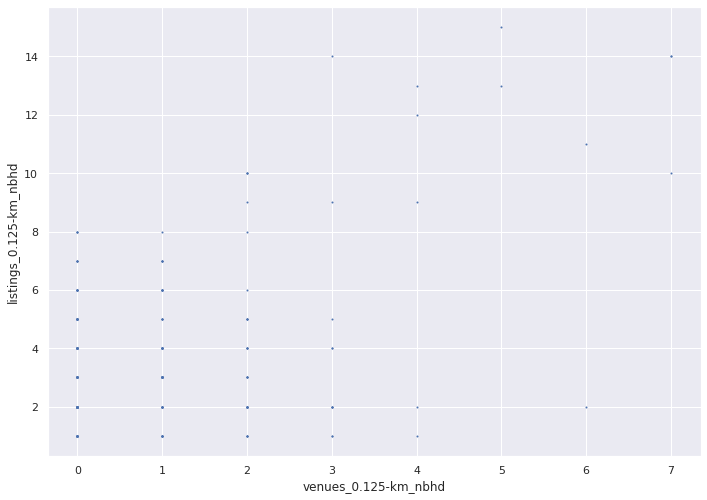

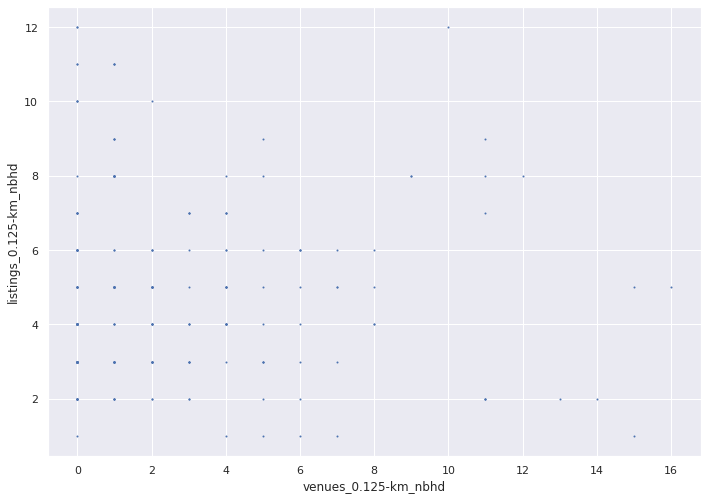

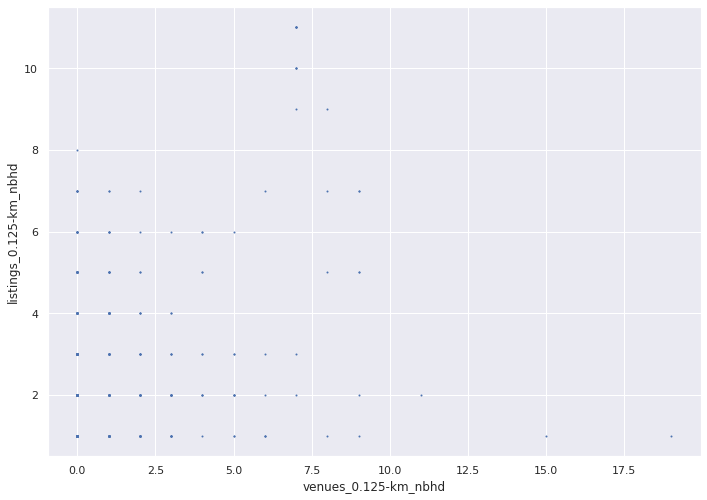

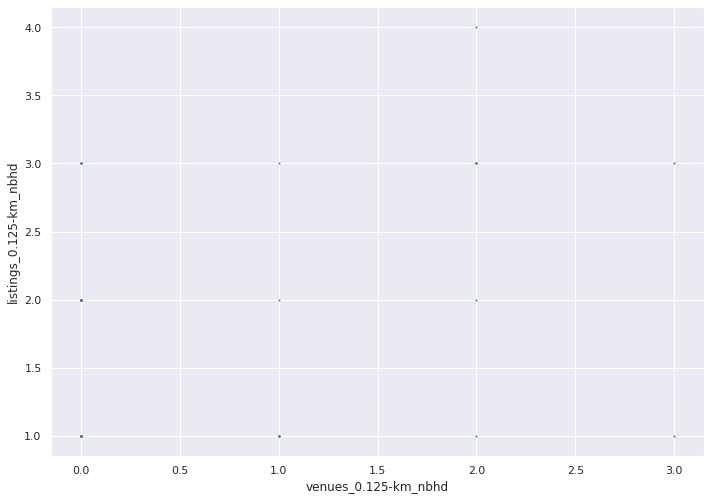

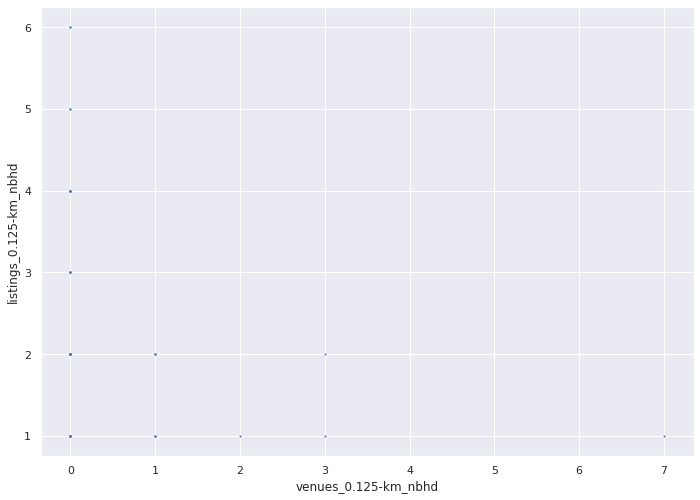

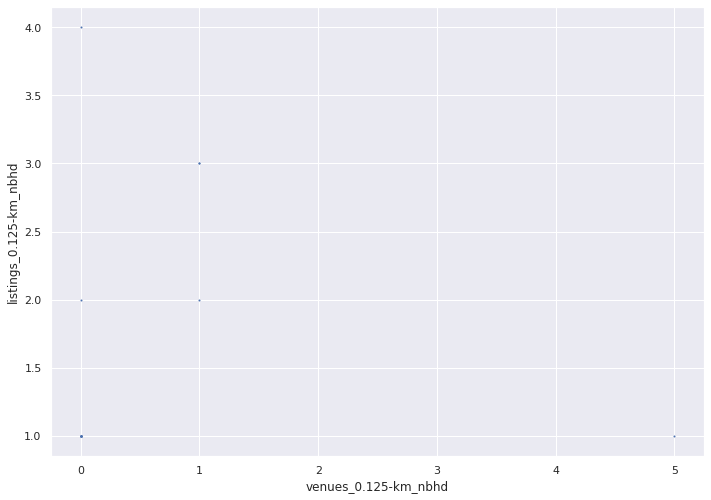

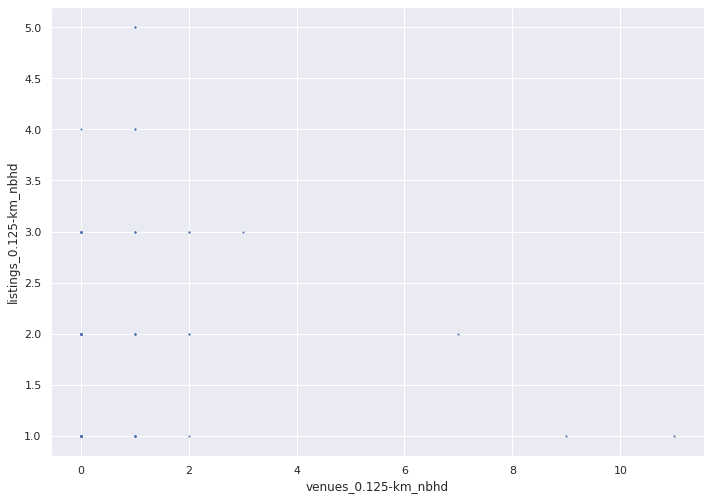

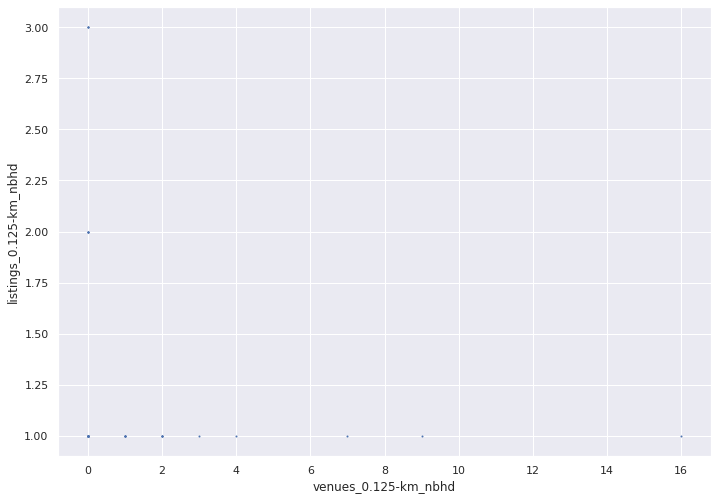

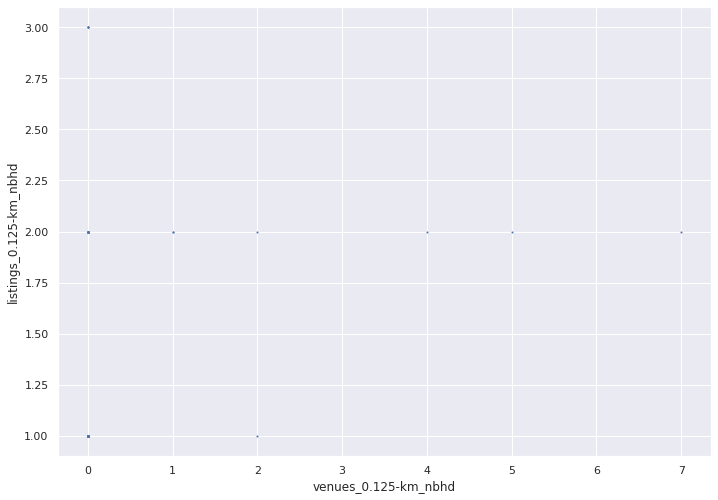

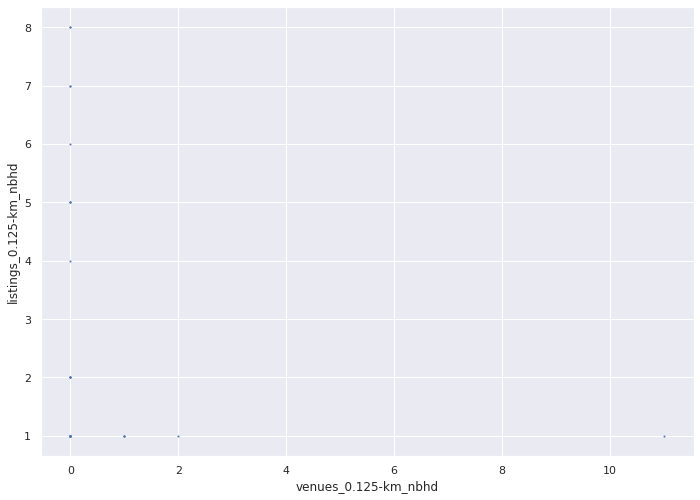

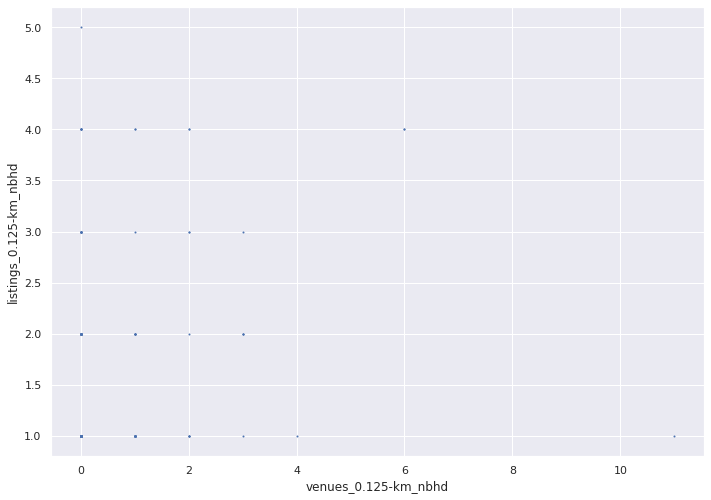

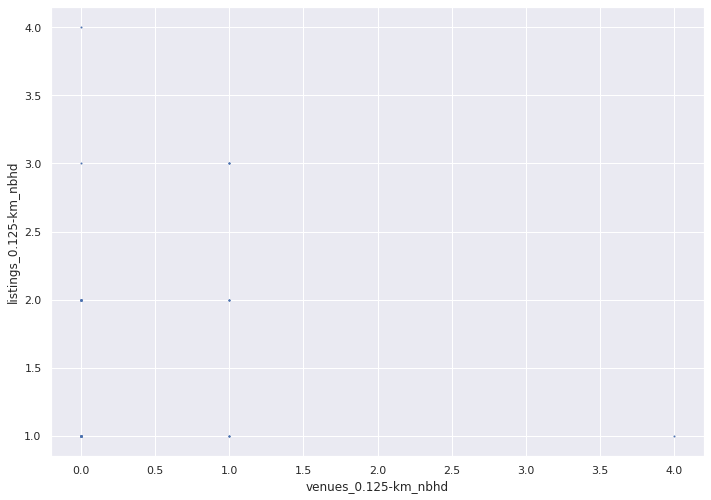

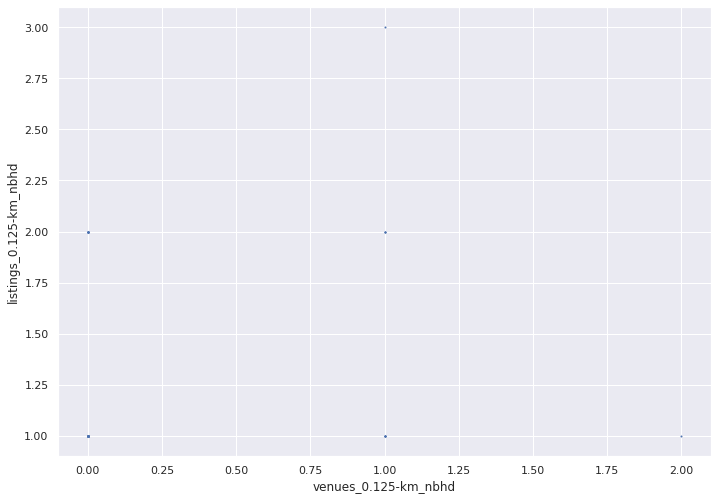

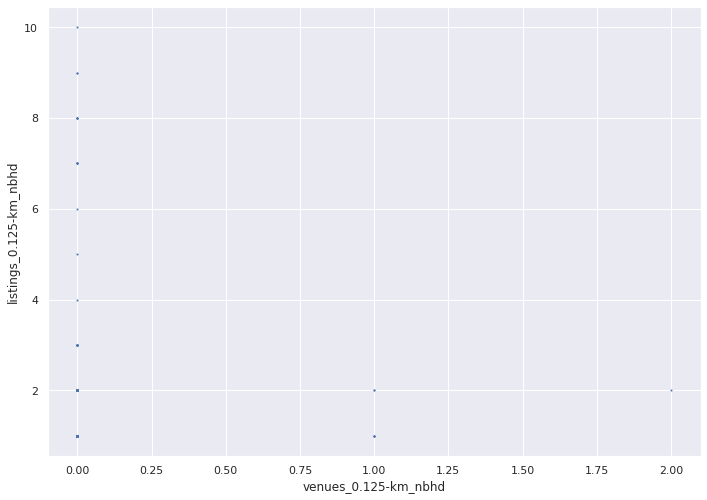

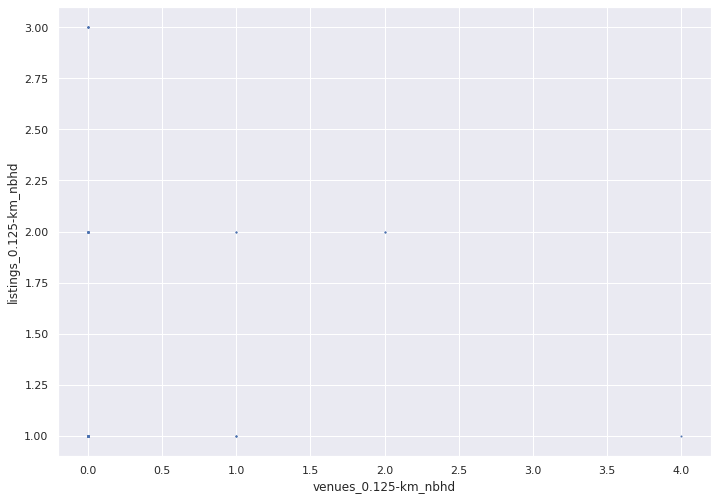

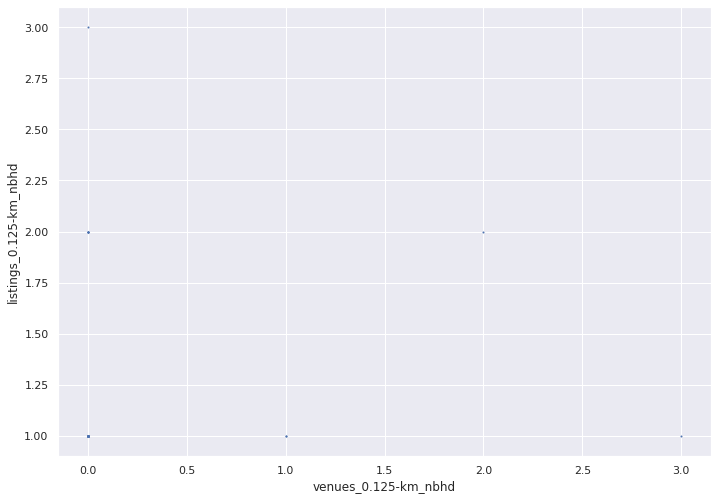

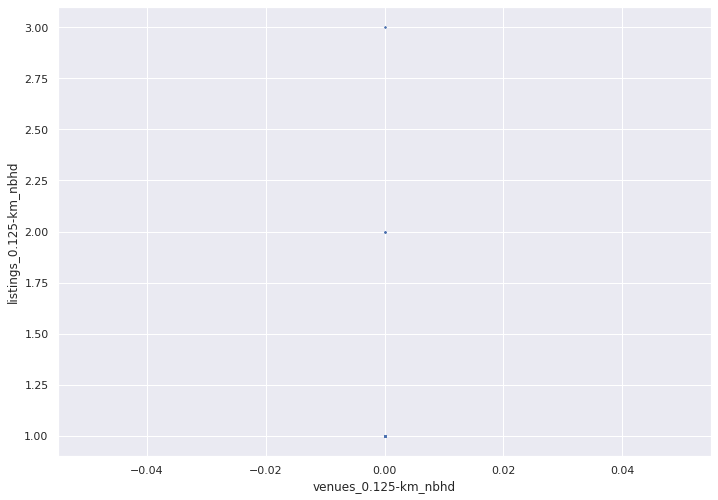

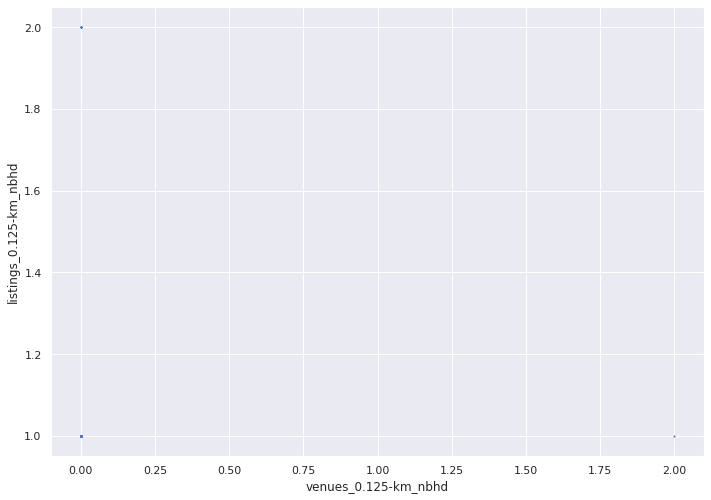

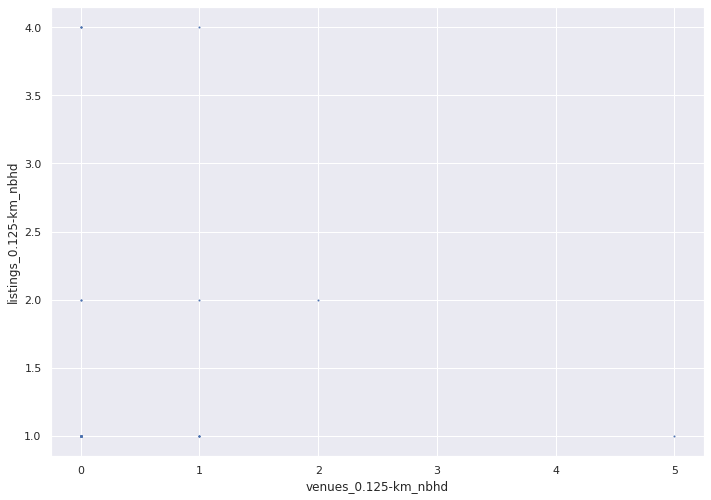

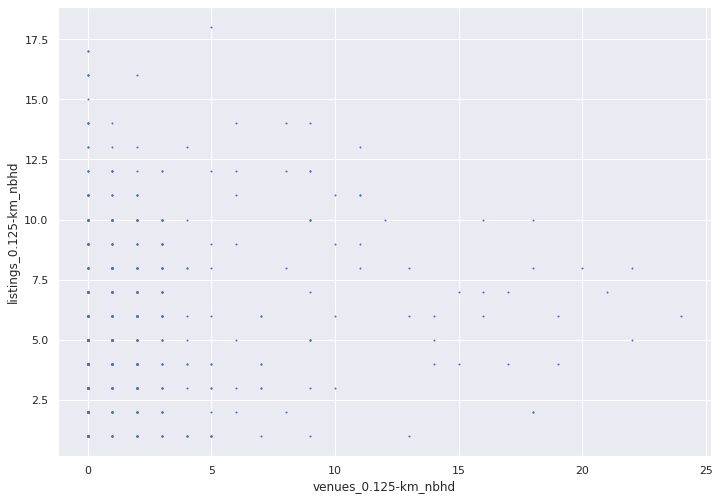

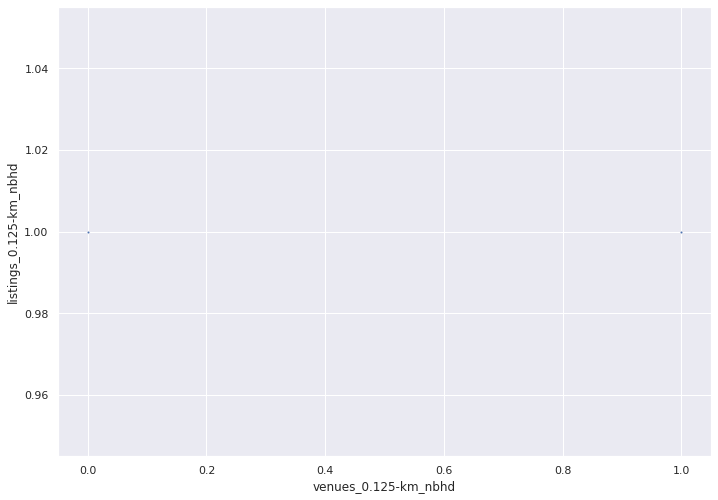

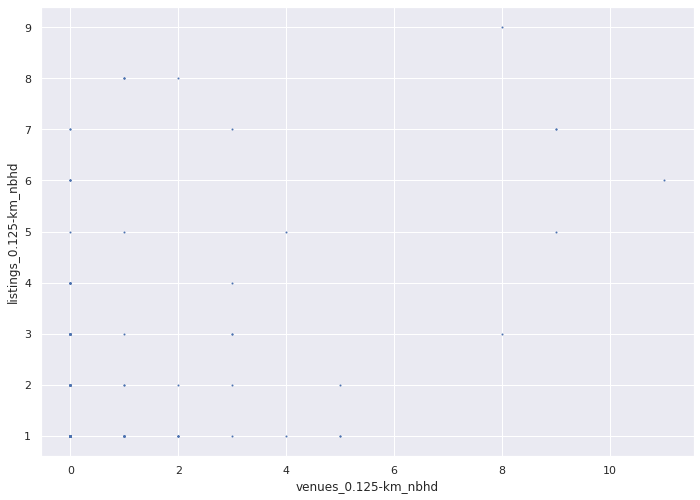

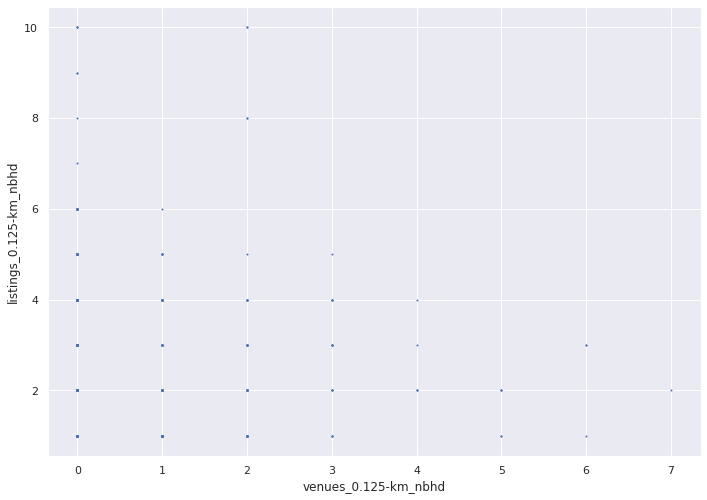

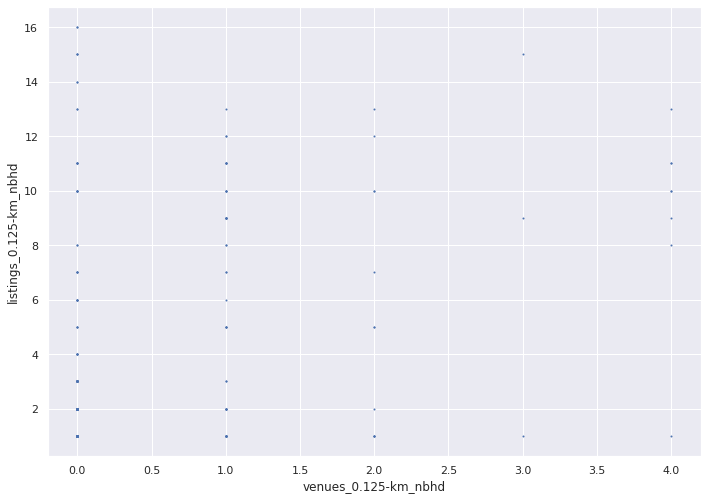

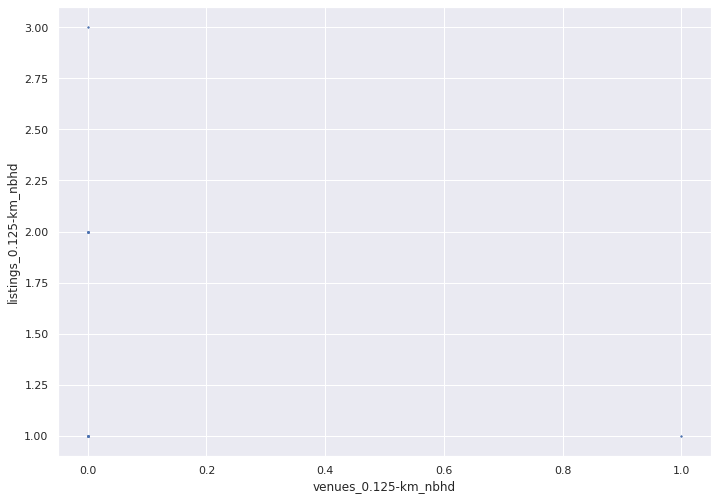

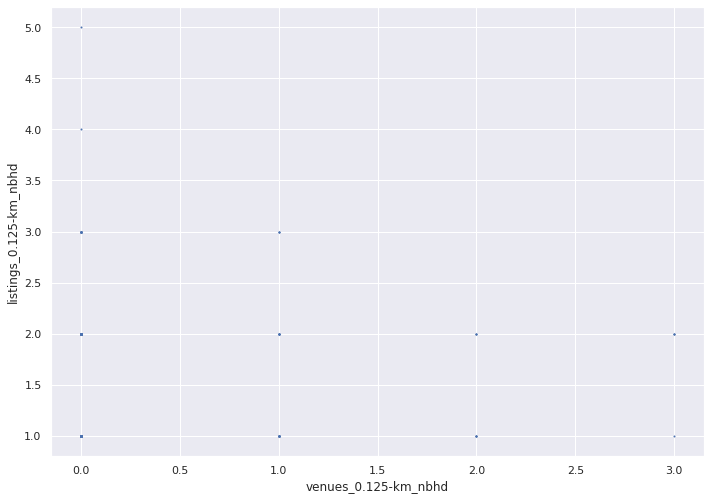

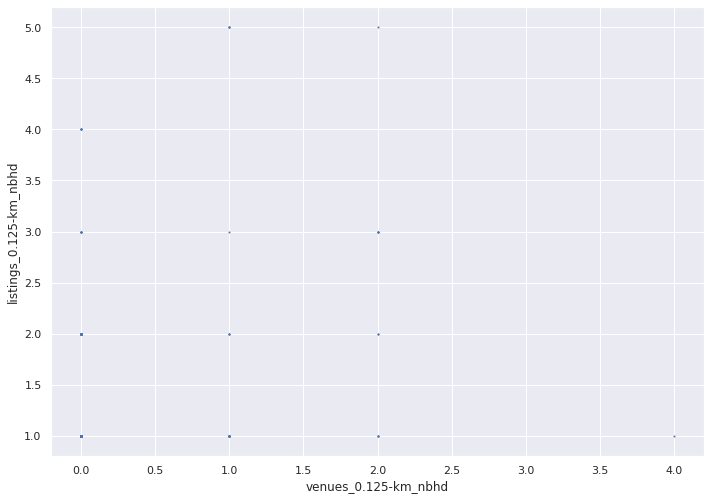

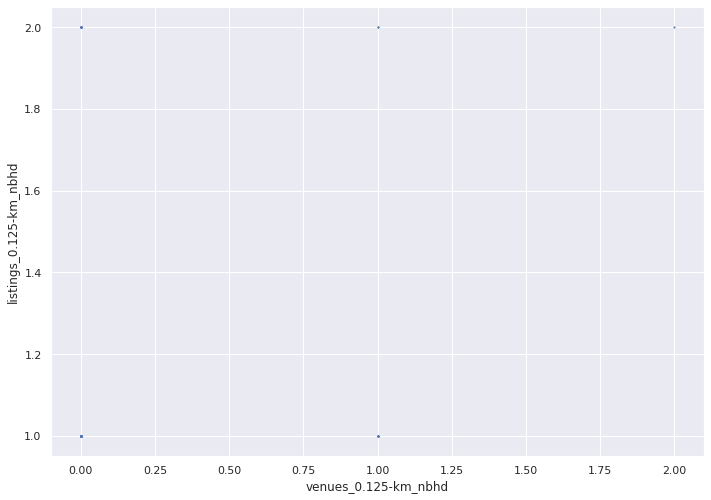

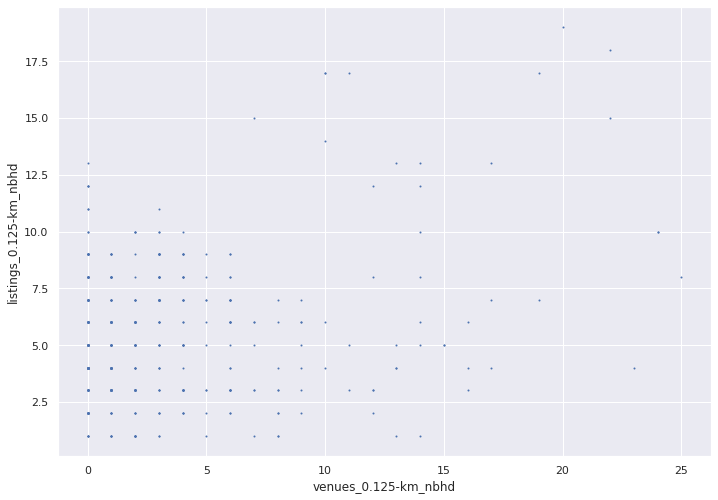

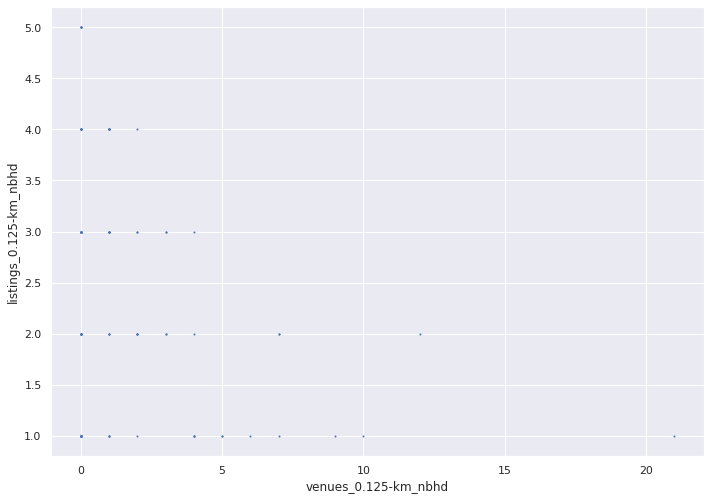

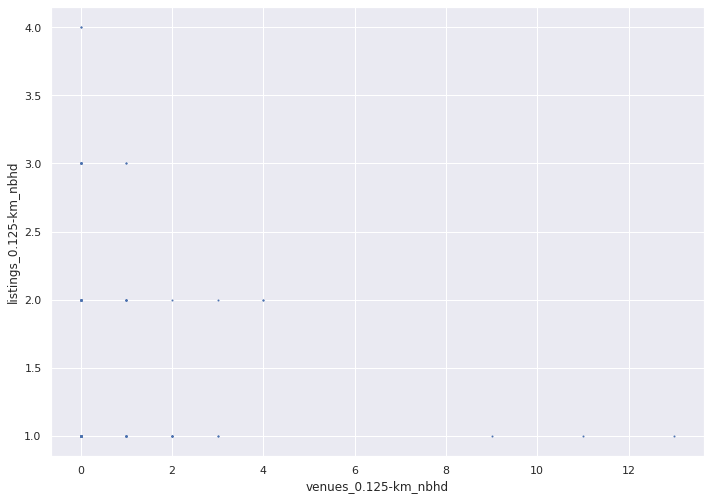

Error in callback <function flush_figures at 0x7f0803601dd0> (for post_execute):


KeyboardInterrupt: ignored

In [118]:
df_melt = df.melt(id_vars = 'cls',
                  value_vars = ['accuracy',
                                'auc',
                                'ppv',
                                'sensitivity',
                                'specificity'],
                  var_name = 'columns')